In [24]:
import pandas as pd
from fastai.vision.all import *

learn = load_learner("model/resnet34/model.pkl")

/opt/anaconda3/lib/python3.10/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


In [25]:
df = pd.read_csv("data/bodyfat_dataset.csv")

In [26]:
df = df.drop(index=176)

df.to_csv("data/bodyfat_dataset.csv", index=False)

In [27]:
def create_regression_csv(df, output_csv="data/image_labels.csv", label_col="meanPrediction", image_prefix="image_", output_dir="images"):
    # Ensure column names are stripped of whitespace
    df.columns = df.columns.str.strip()
    
    image_cols = [col for col in df.columns if col.startswith(image_prefix)]
    records = []

    for idx, row in df.iterrows():
        label = row[label_col]
        for col in image_cols:
            url = row.get(col)
            if isinstance(url, str) and url.startswith("http"):
                ext = url.split('.')[-1].split('?')[0].lower()
                ext = ext if ext in ['jpg', 'jpeg', 'png', 'webp'] else 'jpg'
                filename = f"{idx}_{col}.{ext}"
                records.append({"filename": filename, "target": label})
    
    df_out = pd.DataFrame(records)
    df_out.to_csv(output_csv, index=False)
    print(f"Created {output_csv} with {len(df_out)} labeled images")
    return df_out

In [28]:
create_regression_csv(df)

Created data/image_labels.csv with 1583 labeled images


,filename,target
0,0_image_1.jpg,8.0
1,0_image_2.jpg,8.0
2,0_image_3.jpg,8.0
3,0_image_4.jpg,8.0
4,1_image_1.jpg,9.8
...,...,...
1578,793_image_1.jpg,12.0
1579,794_image_1.jpg,10.5
1580,795_image_1.jpg,15.0
1581,796_image_1.jpg,12.0


In [29]:
from fastai.vision.all import PILImage, show_image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt


In [30]:
df = pd.read_csv('data/image_labels.csv')
df

,filename,target
0,0_image_1.jpg,8.0
1,0_image_2.jpg,8.0
2,0_image_3.jpg,8.0
3,0_image_4.jpg,8.0
4,1_image_1.jpg,9.8
...,...,...
1578,793_image_1.jpg,12.0
1579,794_image_1.jpg,10.5
1580,795_image_1.jpg,15.0
1581,796_image_1.jpg,12.0


Processing images:   0%|                                                                                       | 0/1583 [00:00<?, ?it/s]

Skipping 0_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/0_image_1.jpg'
Skipping 0_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/0_image_2.jpg'
Skipping 0_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/0_image_3.jpg'


Processing images:   0%|                                                                      | 0/1583 [00:00<?, ?it/s, last_error=0.87]

Processing images:   0%|▏                                                             | 5/1583 [00:00<00:44, 35.71it/s, last_error=0.45]

Skipping 2_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/2_image_1.jpg'


Processing images:   0%|▏                                                             | 5/1583 [00:00<00:44, 35.71it/s, last_error=1.30]

Processing images:   0%|▏                                                             | 5/1583 [00:00<00:44, 35.71it/s, last_error=5.18]

Processing images:   1%|▎                                                             | 9/1583 [00:00<00:51, 30.42it/s, last_error=0.18]

Skipping 4_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/4_image_2.jpg'
Skipping 4_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/4_image_3.jpg'
Skipping 5_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/5_image_1.png'


Processing images:   1%|▎                                                             | 9/1583 [00:00<00:51, 30.42it/s, last_error=1.46]

Skipping 7_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/7_image_1.jpg'
Skipping 7_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/7_image_2.jpg'
Skipping 7_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/7_image_3.jpg'
Skipping 7_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/7_image_4.jpg'
Skipping 8_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/8_image_1.jpg'


Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=0.28]

Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=1.10]

Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=0.27]

Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=0.70]

Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=1.62]

Processing images:   1%|▋                                                            | 19/1583 [00:00<00:30, 51.65it/s, last_error=5.88]

Processing images:   2%|▉                                                            | 25/1583 [00:00<00:57, 26.88it/s, last_error=0.51]

Processing images:   2%|▉                                                            | 25/1583 [00:00<00:57, 26.88it/s, last_error=0.48]

Processing images:   2%|▉                                                            | 25/1583 [00:00<00:57, 26.88it/s, last_error=1.06]

Skipping 13_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/13_image_1.jpeg'


Processing images:   2%|█                                                            | 29/1583 [00:00<00:56, 27.44it/s, last_error=1.97]

Processing images:   2%|█                                                            | 29/1583 [00:01<00:56, 27.44it/s, last_error=0.72]

Processing images:   2%|█                                                            | 29/1583 [00:01<00:56, 27.44it/s, last_error=0.16]

Processing images:   2%|█▎                                                           | 33/1583 [00:01<00:56, 27.21it/s, last_error=1.03]

Skipping 16_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/16_image_2.jpg'


Processing images:   2%|█▎                                                           | 33/1583 [00:01<00:56, 27.21it/s, last_error=0.24]

Processing images:   2%|█▎                                                           | 33/1583 [00:01<00:56, 27.21it/s, last_error=1.12]

Processing images:   2%|█▍                                                           | 37/1583 [00:01<01:00, 25.76it/s, last_error=0.95]

Skipping 18_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/18_image_1.jpg'


Processing images:   2%|█▍                                                           | 37/1583 [00:01<01:00, 25.76it/s, last_error=0.87]

Processing images:   2%|█▍                                                           | 37/1583 [00:01<01:00, 25.76it/s, last_error=0.03]

Processing images:   3%|█▌                                                           | 40/1583 [00:01<01:06, 23.24it/s, last_error=0.17]

Skipping 20_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/20_image_1.jpg'
Skipping 20_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/20_image_2.jpg'


Processing images:   3%|█▌                                                           | 40/1583 [00:01<01:06, 23.24it/s, last_error=0.70]

Processing images:   3%|█▋                                                           | 44/1583 [00:01<00:57, 26.60it/s, last_error=1.43]

Processing images:   3%|█▋                                                           | 44/1583 [00:01<00:57, 26.60it/s, last_error=1.37]

Processing images:   3%|█▋                                                           | 44/1583 [00:01<00:57, 26.60it/s, last_error=0.22]

Processing images:   3%|█▊                                                           | 47/1583 [00:01<01:01, 24.89it/s, last_error=0.05]

Processing images:   3%|█▊                                                           | 47/1583 [00:01<01:01, 24.89it/s, last_error=0.61]

Processing images:   3%|█▊                                                           | 47/1583 [00:01<01:01, 24.89it/s, last_error=0.87]

Processing images:   3%|█▉                                                           | 50/1583 [00:01<01:04, 23.87it/s, last_error=0.16]

Processing images:   3%|█▉                                                           | 50/1583 [00:01<01:04, 23.87it/s, last_error=1.98]

Processing images:   3%|█▉                                                           | 50/1583 [00:01<01:04, 23.87it/s, last_error=1.40]

Processing images:   3%|██                                                           | 53/1583 [00:02<01:10, 21.81it/s, last_error=1.10]

Processing images:   3%|██                                                           | 53/1583 [00:02<01:10, 21.81it/s, last_error=0.55]

Processing images:   4%|██▏                                                          | 56/1583 [00:02<01:06, 23.06it/s, last_error=0.22]

Skipping 26_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/26_image_4.jpg'


Processing images:   4%|██▏                                                          | 56/1583 [00:02<01:06, 23.06it/s, last_error=2.32]

Processing images:   4%|██▏                                                          | 56/1583 [00:02<01:06, 23.06it/s, last_error=0.21]

Processing images:   4%|██▎                                                          | 59/1583 [00:02<01:11, 21.25it/s, last_error=1.56]

Processing images:   4%|██▎                                                          | 59/1583 [00:02<01:11, 21.25it/s, last_error=1.59]

Processing images:   4%|██▎                                                          | 59/1583 [00:02<01:11, 21.25it/s, last_error=1.41]

Processing images:   4%|██▍                                                          | 62/1583 [00:02<01:12, 21.12it/s, last_error=1.57]

Processing images:   4%|██▍                                                          | 62/1583 [00:02<01:12, 21.12it/s, last_error=0.48]

Processing images:   4%|██▍                                                          | 62/1583 [00:02<01:12, 21.12it/s, last_error=0.59]

Processing images:   4%|██▌                                                          | 65/1583 [00:02<01:15, 19.99it/s, last_error=0.86]

Processing images:   4%|██▌                                                          | 65/1583 [00:02<01:15, 19.99it/s, last_error=0.03]

Processing images:   4%|██▌                                                          | 65/1583 [00:02<01:15, 19.99it/s, last_error=0.34]

Processing images:   4%|██▌                                                          | 68/1583 [00:02<01:18, 19.29it/s, last_error=2.62]

Processing images:   4%|██▌                                                          | 68/1583 [00:02<01:18, 19.29it/s, last_error=0.64]

Skipping 33_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/33_image_3.jpg'


Processing images:   4%|██▋                                                          | 71/1583 [00:02<01:10, 21.33it/s, last_error=0.49]

Processing images:   4%|██▋                                                          | 71/1583 [00:02<01:10, 21.33it/s, last_error=0.15]

Processing images:   4%|██▋                                                          | 71/1583 [00:03<01:10, 21.33it/s, last_error=0.25]

Processing images:   5%|██▊                                                          | 74/1583 [00:03<01:14, 20.15it/s, last_error=3.64]

Processing images:   5%|██▊                                                          | 74/1583 [00:03<01:14, 20.15it/s, last_error=0.89]

Processing images:   5%|██▊                                                          | 74/1583 [00:03<01:14, 20.15it/s, last_error=0.25]

Processing images:   5%|██▉                                                          | 77/1583 [00:03<01:14, 20.14it/s, last_error=0.66]

Processing images:   5%|██▉                                                          | 77/1583 [00:03<01:14, 20.14it/s, last_error=1.58]

Processing images:   5%|██▉                                                          | 77/1583 [00:03<01:14, 20.14it/s, last_error=0.53]

Processing images:   5%|███                                                          | 80/1583 [00:03<01:16, 19.56it/s, last_error=0.54]

Processing images:   5%|███                                                          | 80/1583 [00:03<01:16, 19.56it/s, last_error=0.67]

Processing images:   5%|███                                                          | 80/1583 [00:03<01:16, 19.56it/s, last_error=0.29]

Processing images:   5%|███▏                                                         | 83/1583 [00:03<01:19, 18.87it/s, last_error=0.26]

Processing images:   5%|███▏                                                         | 83/1583 [00:03<01:19, 18.87it/s, last_error=1.24]

Processing images:   5%|███▎                                                         | 85/1583 [00:03<01:20, 18.65it/s, last_error=1.49]

Processing images:   5%|███▎                                                         | 85/1583 [00:03<01:20, 18.65it/s, last_error=2.40]

Processing images:   5%|███▎                                                         | 85/1583 [00:03<01:20, 18.65it/s, last_error=0.51]

Processing images:   6%|███▍                                                         | 88/1583 [00:03<01:17, 19.27it/s, last_error=1.65]

Processing images:   6%|███▍                                                         | 88/1583 [00:03<01:17, 19.27it/s, last_error=0.39]

Processing images:   6%|███▍                                                         | 88/1583 [00:03<01:17, 19.27it/s, last_error=1.77]

Processing images:   6%|███▌                                                         | 91/1583 [00:03<01:15, 19.74it/s, last_error=0.79]

Processing images:   6%|███▌                                                         | 91/1583 [00:04<01:15, 19.74it/s, last_error=1.24]

Processing images:   6%|███▌                                                         | 93/1583 [00:04<01:22, 17.96it/s, last_error=1.29]

Processing images:   6%|███▌                                                         | 93/1583 [00:04<01:22, 17.96it/s, last_error=0.21]

Skipping 45_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/45_image_2.jpg'


Processing images:   6%|███▋                                                         | 96/1583 [00:04<01:13, 20.34it/s, last_error=0.44]

Processing images:   6%|███▋                                                         | 96/1583 [00:04<01:13, 20.34it/s, last_error=1.51]

Processing images:   6%|███▋                                                         | 96/1583 [00:04<01:13, 20.34it/s, last_error=2.17]

Processing images:   6%|███▊                                                         | 99/1583 [00:04<01:22, 17.96it/s, last_error=0.60]

Processing images:   6%|███▊                                                         | 99/1583 [00:04<01:22, 17.96it/s, last_error=2.86]

Processing images:   6%|███▊                                                        | 101/1583 [00:04<01:20, 18.36it/s, last_error=5.28]

Processing images:   6%|███▊                                                        | 101/1583 [00:04<01:20, 18.36it/s, last_error=1.45]

Processing images:   7%|███▉                                                        | 103/1583 [00:04<01:20, 18.41it/s, last_error=0.74]

Processing images:   7%|███▉                                                        | 103/1583 [00:04<01:20, 18.41it/s, last_error=1.40]

Processing images:   7%|███▉                                                        | 105/1583 [00:04<01:20, 18.31it/s, last_error=0.59]

Processing images:   7%|███▉                                                        | 105/1583 [00:04<01:20, 18.31it/s, last_error=1.24]

Processing images:   7%|████                                                        | 107/1583 [00:04<01:19, 18.63it/s, last_error=3.97]

Processing images:   7%|████                                                        | 107/1583 [00:04<01:19, 18.63it/s, last_error=3.55]

Processing images:   7%|████▏                                                       | 109/1583 [00:04<01:19, 18.47it/s, last_error=0.69]

Processing images:   7%|████▏                                                       | 109/1583 [00:04<01:19, 18.47it/s, last_error=0.44]

Processing images:   7%|████▏                                                       | 111/1583 [00:05<01:20, 18.27it/s, last_error=0.03]

Processing images:   7%|████▏                                                       | 111/1583 [00:05<01:20, 18.27it/s, last_error=0.63]

Processing images:   7%|████▏                                                       | 111/1583 [00:05<01:20, 18.27it/s, last_error=0.03]

Processing images:   7%|████▎                                                       | 114/1583 [00:05<01:16, 19.15it/s, last_error=3.11]

Processing images:   7%|████▎                                                       | 114/1583 [00:05<01:16, 19.15it/s, last_error=0.08]

Processing images:   7%|████▎                                                       | 114/1583 [00:05<01:16, 19.15it/s, last_error=1.16]

Processing images:   7%|████▍                                                       | 117/1583 [00:05<01:15, 19.51it/s, last_error=0.51]

Processing images:   7%|████▍                                                       | 117/1583 [00:05<01:15, 19.51it/s, last_error=0.96]

Processing images:   8%|████▌                                                       | 119/1583 [00:05<01:15, 19.36it/s, last_error=0.22]

Processing images:   8%|████▌                                                       | 119/1583 [00:05<01:15, 19.36it/s, last_error=1.19]

Processing images:   8%|████▌                                                       | 119/1583 [00:05<01:15, 19.36it/s, last_error=1.20]

Processing images:   8%|████▌                                                       | 122/1583 [00:05<01:13, 19.84it/s, last_error=4.92]

Processing images:   8%|████▌                                                       | 122/1583 [00:05<01:13, 19.84it/s, last_error=2.72]

Processing images:   8%|████▌                                                      | 122/1583 [00:05<01:13, 19.84it/s, last_error=15.72]

Skipping 56_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/56_image_4.jpg'
Skipping 57_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/57_image_1.jpg'


Processing images:   8%|████▊                                                       | 127/1583 [00:05<00:58, 25.07it/s, last_error=2.05]

Processing images:   8%|████▊                                                       | 127/1583 [00:05<00:58, 25.07it/s, last_error=0.68]

Processing images:   8%|████▊                                                       | 127/1583 [00:05<00:58, 25.07it/s, last_error=0.29]

Skipping 58_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/58_image_1.jpg'
Skipping 59_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/59_image_1.jpg'


Processing images:   8%|█████                                                       | 132/1583 [00:05<00:50, 28.86it/s, last_error=0.19]

Processing images:   8%|█████                                                       | 132/1583 [00:05<00:50, 28.86it/s, last_error=0.43]

Processing images:   8%|█████                                                       | 132/1583 [00:05<00:50, 28.86it/s, last_error=0.70]

Processing images:   9%|█████                                                       | 135/1583 [00:06<00:57, 25.15it/s, last_error=0.83]

Processing images:   9%|█████                                                       | 135/1583 [00:06<00:57, 25.15it/s, last_error=2.31]

Processing images:   9%|█████                                                       | 135/1583 [00:06<00:57, 25.15it/s, last_error=1.16]

Processing images:   9%|█████▏                                                      | 138/1583 [00:06<00:59, 24.47it/s, last_error=1.13]

Processing images:   9%|█████▏                                                      | 138/1583 [00:06<00:59, 24.47it/s, last_error=0.31]

Processing images:   9%|█████▏                                                      | 138/1583 [00:06<00:59, 24.47it/s, last_error=2.00]

Processing images:   9%|█████▎                                                      | 141/1583 [00:06<01:00, 23.77it/s, last_error=0.67]

Processing images:   9%|█████▎                                                      | 141/1583 [00:06<01:00, 23.77it/s, last_error=2.50]

Processing images:   9%|█████▎                                                      | 141/1583 [00:06<01:00, 23.77it/s, last_error=1.06]

Processing images:   9%|█████▍                                                      | 144/1583 [00:06<01:01, 23.49it/s, last_error=2.38]

Processing images:   9%|█████▍                                                      | 144/1583 [00:06<01:01, 23.49it/s, last_error=1.92]

Processing images:   9%|█████▍                                                      | 144/1583 [00:06<01:01, 23.49it/s, last_error=0.06]

Processing images:   9%|█████▌                                                      | 147/1583 [00:06<01:08, 20.86it/s, last_error=0.10]

Processing images:   9%|█████▌                                                      | 147/1583 [00:06<01:08, 20.86it/s, last_error=0.33]

Processing images:   9%|█████▌                                                      | 147/1583 [00:06<01:08, 20.86it/s, last_error=0.67]

Processing images:   9%|█████▋                                                      | 150/1583 [00:06<01:14, 19.25it/s, last_error=0.83]

Skipping 69_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/69_image_1.jpg'


Processing images:   9%|█████▋                                                      | 150/1583 [00:06<01:14, 19.25it/s, last_error=0.97]

Processing images:  10%|█████▊                                                      | 153/1583 [00:06<01:08, 20.87it/s, last_error=1.91]

Processing images:  10%|█████▊                                                      | 153/1583 [00:06<01:08, 20.87it/s, last_error=6.14]

Processing images:  10%|█████▊                                                      | 153/1583 [00:07<01:08, 20.87it/s, last_error=1.73]

Processing images:  10%|█████▉                                                      | 156/1583 [00:07<01:10, 20.37it/s, last_error=3.59]

Processing images:  10%|█████▉                                                      | 156/1583 [00:07<01:10, 20.37it/s, last_error=2.35]

Processing images:  10%|█████▉                                                      | 156/1583 [00:07<01:10, 20.37it/s, last_error=0.74]

Processing images:  10%|██████                                                      | 159/1583 [00:07<01:10, 20.18it/s, last_error=2.00]

Processing images:  10%|██████                                                      | 159/1583 [00:07<01:10, 20.18it/s, last_error=0.68]

Processing images:  10%|██████                                                      | 159/1583 [00:07<01:10, 20.18it/s, last_error=0.16]

Processing images:  10%|██████▏                                                     | 162/1583 [00:07<01:13, 19.43it/s, last_error=0.18]

Processing images:  10%|██████▏                                                     | 162/1583 [00:07<01:13, 19.43it/s, last_error=2.91]

Processing images:  10%|██████▏                                                     | 164/1583 [00:07<01:13, 19.38it/s, last_error=2.94]

Processing images:  10%|██████▏                                                     | 164/1583 [00:07<01:13, 19.38it/s, last_error=0.14]

Processing images:  10%|██████▎                                                     | 166/1583 [00:07<01:15, 18.72it/s, last_error=0.58]

Processing images:  10%|██████▎                                                     | 166/1583 [00:07<01:15, 18.72it/s, last_error=0.08]

Processing images:  10%|██████▎                                                     | 166/1583 [00:07<01:15, 18.72it/s, last_error=0.21]

Processing images:  11%|██████▍                                                     | 169/1583 [00:07<01:12, 19.39it/s, last_error=1.48]

Processing images:  11%|██████▍                                                     | 169/1583 [00:07<01:12, 19.39it/s, last_error=0.73]

Processing images:  11%|██████▍                                                     | 171/1583 [00:07<01:15, 18.82it/s, last_error=0.53]

Processing images:  11%|██████▍                                                     | 171/1583 [00:07<01:15, 18.82it/s, last_error=1.52]

Processing images:  11%|██████▌                                                     | 173/1583 [00:07<01:14, 18.96it/s, last_error=1.03]

Processing images:  11%|██████▌                                                     | 173/1583 [00:08<01:14, 18.96it/s, last_error=0.34]

Skipping 77_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/77_image_3.jpg'


Processing images:  11%|██████▌                                                     | 173/1583 [00:08<01:14, 18.96it/s, last_error=0.70]

Processing images:  11%|██████▋                                                     | 177/1583 [00:08<01:03, 22.05it/s, last_error=0.80]

Processing images:  11%|██████▋                                                     | 177/1583 [00:08<01:03, 22.05it/s, last_error=1.83]

Skipping 78_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/78_image_3.jpg'
Skipping 78_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/78_image_4.jpg'


Processing images:  11%|██████▊                                                     | 181/1583 [00:08<00:54, 25.92it/s, last_error=0.60]

Processing images:  11%|██████▊                                                     | 181/1583 [00:08<00:54, 25.92it/s, last_error=0.04]

Processing images:  11%|██████▊                                                     | 181/1583 [00:08<00:54, 25.92it/s, last_error=0.54]

Processing images:  12%|██████▉                                                     | 184/1583 [00:08<01:07, 20.83it/s, last_error=0.98]

Processing images:  12%|██████▉                                                     | 184/1583 [00:08<01:07, 20.83it/s, last_error=1.44]

Skipping 83_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/83_image_1.jpg'


Processing images:  12%|███████                                                     | 187/1583 [00:08<01:04, 21.69it/s, last_error=1.06]

Processing images:  12%|███████                                                     | 187/1583 [00:08<01:04, 21.69it/s, last_error=1.38]

Processing images:  12%|███████▏                                                    | 190/1583 [00:08<00:59, 23.25it/s, last_error=1.59]

Skipping 84_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/84_image_4.jpg'


Processing images:  12%|███████▏                                                    | 190/1583 [00:08<00:59, 23.25it/s, last_error=0.33]

Processing images:  12%|███████▏                                                    | 190/1583 [00:08<00:59, 23.25it/s, last_error=0.12]

Processing images:  12%|███████▎                                                    | 193/1583 [00:08<01:06, 20.77it/s, last_error=1.23]

Processing images:  12%|███████▎                                                    | 193/1583 [00:08<01:06, 20.77it/s, last_error=0.95]

Processing images:  12%|███████▎                                                    | 193/1583 [00:08<01:06, 20.77it/s, last_error=0.11]

Processing images:  12%|███████▍                                                    | 196/1583 [00:09<01:09, 19.84it/s, last_error=0.55]

Processing images:  12%|███████▍                                                    | 196/1583 [00:09<01:09, 19.84it/s, last_error=0.03]

Processing images:  12%|███████▍                                                    | 196/1583 [00:09<01:09, 19.84it/s, last_error=0.17]

Processing images:  13%|███████▌                                                    | 199/1583 [00:09<01:25, 16.10it/s, last_error=0.90]

Processing images:  13%|███████▌                                                    | 199/1583 [00:09<01:25, 16.10it/s, last_error=0.26]

Processing images:  13%|███████▌                                                    | 201/1583 [00:09<01:23, 16.65it/s, last_error=0.16]

Processing images:  13%|███████▌                                                    | 201/1583 [00:09<01:23, 16.65it/s, last_error=0.71]

Processing images:  13%|███████▋                                                    | 203/1583 [00:09<01:20, 17.09it/s, last_error=0.40]

Processing images:  13%|███████▋                                                    | 203/1583 [00:09<01:20, 17.09it/s, last_error=1.17]

Processing images:  13%|███████▊                                                    | 205/1583 [00:09<01:20, 17.03it/s, last_error=1.88]

Processing images:  13%|███████▊                                                    | 205/1583 [00:09<01:20, 17.03it/s, last_error=1.23]

Processing images:  13%|███████▊                                                    | 207/1583 [00:09<01:19, 17.36it/s, last_error=0.89]

Processing images:  13%|███████▊                                                    | 207/1583 [00:09<01:19, 17.36it/s, last_error=2.87]

Processing images:  13%|███████▉                                                    | 209/1583 [00:09<01:22, 16.65it/s, last_error=1.25]

Processing images:  13%|███████▉                                                    | 209/1583 [00:09<01:22, 16.65it/s, last_error=1.39]

Processing images:  13%|███████▉                                                    | 211/1583 [00:09<01:21, 16.87it/s, last_error=0.03]

Processing images:  13%|███████▉                                                    | 211/1583 [00:10<01:21, 16.87it/s, last_error=1.86]

Processing images:  13%|████████                                                    | 213/1583 [00:10<01:23, 16.46it/s, last_error=1.29]

Processing images:  13%|████████                                                    | 213/1583 [00:10<01:23, 16.46it/s, last_error=1.46]

Processing images:  14%|████████▏                                                   | 215/1583 [00:10<01:22, 16.62it/s, last_error=1.15]

Processing images:  14%|████████▏                                                   | 215/1583 [00:10<01:22, 16.62it/s, last_error=1.41]

Processing images:  14%|████████▏                                                   | 217/1583 [00:10<01:24, 16.15it/s, last_error=0.84]

Processing images:  14%|████████▏                                                   | 217/1583 [00:10<01:24, 16.15it/s, last_error=2.27]

Processing images:  14%|████████▎                                                   | 219/1583 [00:10<01:20, 16.94it/s, last_error=1.68]

Processing images:  14%|████████▎                                                   | 219/1583 [00:10<01:20, 16.94it/s, last_error=0.54]

Processing images:  14%|████████▍                                                   | 221/1583 [00:10<01:25, 15.98it/s, last_error=2.05]

Processing images:  14%|████████▍                                                   | 221/1583 [00:10<01:25, 15.98it/s, last_error=0.09]

Processing images:  14%|████████▍                                                   | 221/1583 [00:10<01:25, 15.98it/s, last_error=0.16]

Processing images:  14%|████████▍                                                   | 224/1583 [00:10<01:17, 17.49it/s, last_error=1.56]

Processing images:  14%|████████▍                                                   | 224/1583 [00:10<01:17, 17.49it/s, last_error=1.13]

Processing images:  14%|████████▍                                                   | 224/1583 [00:10<01:17, 17.49it/s, last_error=0.92]

Skipping 109_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/109_image_3.jpg'


Processing images:  14%|████████▋                                                   | 228/1583 [00:10<01:04, 21.00it/s, last_error=3.70]

Processing images:  14%|████████▋                                                   | 228/1583 [00:10<01:04, 21.00it/s, last_error=3.48]

Skipping 111_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/111_image_1.jpeg'


Processing images:  14%|████████▋                                                   | 228/1583 [00:10<01:04, 21.00it/s, last_error=0.69]

Processing images:  15%|████████▊                                                   | 232/1583 [00:11<00:57, 23.68it/s, last_error=0.62]

Processing images:  15%|████████▊                                                   | 232/1583 [00:11<00:57, 23.68it/s, last_error=0.79]

Processing images:  15%|████████▊                                                   | 232/1583 [00:11<00:57, 23.68it/s, last_error=0.50]

Processing images:  15%|████████▉                                                   | 235/1583 [00:11<01:03, 21.25it/s, last_error=0.46]

Processing images:  15%|████████▉                                                   | 235/1583 [00:11<01:03, 21.25it/s, last_error=0.12]

Skipping 114_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/114_image_4.jpg'


Processing images:  15%|█████████                                                   | 238/1583 [00:11<00:58, 23.00it/s, last_error=3.05]

Processing images:  15%|█████████                                                   | 238/1583 [00:11<00:58, 23.00it/s, last_error=0.34]

Processing images:  15%|█████████                                                   | 238/1583 [00:11<00:58, 23.00it/s, last_error=2.67]

Skipping 115_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/115_image_4.jpg'


Processing images:  15%|█████████▏                                                  | 242/1583 [00:11<00:55, 24.12it/s, last_error=0.61]

Processing images:  15%|█████████▏                                                  | 242/1583 [00:11<00:55, 24.12it/s, last_error=0.49]

Processing images:  15%|█████████▏                                                  | 242/1583 [00:11<00:55, 24.12it/s, last_error=0.74]

Processing images:  15%|█████████▎                                                  | 245/1583 [00:11<00:57, 23.23it/s, last_error=2.46]

Processing images:  15%|█████████▎                                                  | 245/1583 [00:11<00:57, 23.23it/s, last_error=1.30]

Processing images:  15%|█████████▎                                                  | 245/1583 [00:11<00:57, 23.23it/s, last_error=0.78]

Processing images:  16%|█████████▍                                                  | 248/1583 [00:11<01:00, 22.02it/s, last_error=3.89]

Processing images:  16%|█████████▍                                                  | 248/1583 [00:11<01:00, 22.02it/s, last_error=0.90]

Processing images:  16%|█████████▍                                                  | 248/1583 [00:11<01:00, 22.02it/s, last_error=0.45]

Processing images:  16%|█████████▌                                                  | 251/1583 [00:11<01:04, 20.63it/s, last_error=0.18]

Processing images:  16%|█████████▌                                                  | 251/1583 [00:11<01:04, 20.63it/s, last_error=2.44]

Processing images:  16%|█████████▌                                                  | 251/1583 [00:12<01:04, 20.63it/s, last_error=0.10]

Processing images:  16%|█████████▋                                                  | 254/1583 [00:12<01:04, 20.64it/s, last_error=1.60]

Processing images:  16%|█████████▋                                                  | 254/1583 [00:12<01:04, 20.64it/s, last_error=0.52]

Skipping 124_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/124_image_2.jpg'


Processing images:  16%|█████████▋                                                  | 254/1583 [00:12<01:04, 20.64it/s, last_error=0.10]

Processing images:  16%|█████████▊                                                  | 258/1583 [00:12<01:00, 22.04it/s, last_error=5.90]

Processing images:  16%|█████████▊                                                  | 258/1583 [00:12<01:00, 22.04it/s, last_error=0.84]

Processing images:  16%|█████████▊                                                  | 258/1583 [00:12<01:00, 22.04it/s, last_error=2.78]

Skipping 128_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/128_image_1.jpeg'


Processing images:  17%|█████████▉                                                  | 262/1583 [00:12<00:55, 23.61it/s, last_error=4.60]

Processing images:  17%|█████████▉                                                  | 262/1583 [00:12<00:55, 23.61it/s, last_error=1.55]

Processing images:  17%|█████████▉                                                  | 262/1583 [00:12<00:55, 23.61it/s, last_error=0.79]

Processing images:  17%|██████████                                                  | 265/1583 [00:12<00:57, 23.01it/s, last_error=6.28]

Processing images:  17%|██████████                                                  | 265/1583 [00:12<00:57, 23.01it/s, last_error=5.36]

Processing images:  17%|██████████                                                  | 265/1583 [00:12<00:57, 23.01it/s, last_error=2.78]

Processing images:  17%|██████████▏                                                 | 268/1583 [00:12<00:58, 22.64it/s, last_error=1.02]

Processing images:  17%|██████████▏                                                 | 268/1583 [00:12<00:58, 22.64it/s, last_error=2.02]

Processing images:  17%|██████████▏                                                 | 268/1583 [00:12<00:58, 22.64it/s, last_error=3.48]

Processing images:  17%|██████████▎                                                 | 271/1583 [00:12<00:58, 22.35it/s, last_error=1.72]

Processing images:  17%|██████████▎                                                 | 271/1583 [00:12<00:58, 22.35it/s, last_error=3.48]

Processing images:  17%|██████████▎                                                 | 271/1583 [00:12<00:58, 22.35it/s, last_error=2.48]

Processing images:  17%|██████████▍                                                 | 274/1583 [00:12<00:59, 22.09it/s, last_error=1.02]

Processing images:  17%|██████████▍                                                 | 274/1583 [00:12<00:59, 22.09it/s, last_error=0.46]

Processing images:  17%|██████████▍                                                 | 277/1583 [00:13<00:54, 23.89it/s, last_error=2.53]

Skipping 135_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/135_image_1.jpg'


Processing images:  17%|██████████▍                                                 | 277/1583 [00:13<00:54, 23.89it/s, last_error=3.27]

Processing images:  17%|██████████▍                                                 | 277/1583 [00:13<00:54, 23.89it/s, last_error=2.42]

Processing images:  18%|██████████▌                                                 | 280/1583 [00:13<00:59, 21.84it/s, last_error=1.48]

Processing images:  18%|██████████▌                                                 | 280/1583 [00:13<00:59, 21.84it/s, last_error=0.16]

Processing images:  18%|██████████▌                                                 | 280/1583 [00:13<00:59, 21.84it/s, last_error=0.05]

Processing images:  18%|██████████▋                                                 | 283/1583 [00:13<00:59, 21.80it/s, last_error=0.92]

Processing images:  18%|██████████▋                                                 | 283/1583 [00:13<00:59, 21.80it/s, last_error=1.74]

Processing images:  18%|██████████▋                                                 | 283/1583 [00:13<00:59, 21.80it/s, last_error=1.32]

Processing images:  18%|██████████▊                                                 | 286/1583 [00:13<01:02, 20.75it/s, last_error=2.64]

Processing images:  18%|██████████▊                                                 | 286/1583 [00:13<01:02, 20.75it/s, last_error=0.26]

Processing images:  18%|██████████▊                                                 | 286/1583 [00:13<01:02, 20.75it/s, last_error=1.15]

Processing images:  18%|██████████▉                                                 | 289/1583 [00:13<01:06, 19.37it/s, last_error=0.12]

Processing images:  18%|██████████▉                                                 | 289/1583 [00:13<01:06, 19.37it/s, last_error=4.33]

Processing images:  18%|███████████                                                 | 291/1583 [00:13<01:08, 18.99it/s, last_error=0.42]

Processing images:  18%|███████████                                                 | 291/1583 [00:13<01:08, 18.99it/s, last_error=1.04]

Processing images:  18%|███████████                                                 | 291/1583 [00:13<01:08, 18.99it/s, last_error=0.83]

Processing images:  19%|███████████▏                                                | 294/1583 [00:13<01:06, 19.36it/s, last_error=0.32]

Processing images:  19%|███████████▏                                                | 294/1583 [00:13<01:06, 19.36it/s, last_error=0.63]

Processing images:  19%|███████████▏                                                | 296/1583 [00:14<01:06, 19.32it/s, last_error=0.45]

Processing images:  19%|███████████▏                                                | 296/1583 [00:14<01:06, 19.32it/s, last_error=1.28]

Processing images:  19%|███████████▎                                                | 298/1583 [00:14<01:09, 18.43it/s, last_error=7.60]

Processing images:  19%|███████████▎                                                | 298/1583 [00:14<01:09, 18.43it/s, last_error=1.15]

Processing images:  19%|███████████▎                                                | 300/1583 [00:14<01:09, 18.43it/s, last_error=0.29]

Skipping 150_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/150_image_2.jpg'


Processing images:  19%|███████████▎                                                | 300/1583 [00:14<01:09, 18.43it/s, last_error=0.14]

Processing images:  19%|███████████▍                                                | 303/1583 [00:14<01:00, 21.29it/s, last_error=1.62]

Processing images:  19%|███████████▍                                                | 303/1583 [00:14<01:00, 21.29it/s, last_error=1.84]

Processing images:  19%|███████████▍                                                | 303/1583 [00:14<01:00, 21.29it/s, last_error=0.02]

Processing images:  19%|███████████▌                                                | 306/1583 [00:14<01:00, 20.96it/s, last_error=0.36]

Processing images:  19%|███████████▌                                                | 306/1583 [00:14<01:00, 20.96it/s, last_error=3.83]

Processing images:  19%|███████████▌                                                | 306/1583 [00:14<01:00, 20.96it/s, last_error=4.15]

Skipping 154_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/154_image_2.jpg'


Processing images:  20%|███████████▋                                                | 310/1583 [00:14<00:55, 23.05it/s, last_error=4.87]

Processing images:  20%|███████████▋                                                | 310/1583 [00:14<00:55, 23.05it/s, last_error=0.17]

Processing images:  20%|███████████▋                                                | 310/1583 [00:14<00:55, 23.05it/s, last_error=0.08]

Processing images:  20%|███████████▊                                                | 313/1583 [00:14<00:59, 21.51it/s, last_error=1.10]

Processing images:  20%|███████████▊                                                | 313/1583 [00:14<00:59, 21.51it/s, last_error=1.08]

Processing images:  20%|███████████▊                                                | 313/1583 [00:14<00:59, 21.51it/s, last_error=1.87]

Processing images:  20%|███████████▉                                                | 316/1583 [00:14<00:58, 21.52it/s, last_error=0.18]

Processing images:  20%|███████████▉                                                | 316/1583 [00:15<00:58, 21.52it/s, last_error=2.28]

Processing images:  20%|███████████▉                                                | 316/1583 [00:15<00:58, 21.52it/s, last_error=0.32]

Processing images:  20%|████████████                                                | 319/1583 [00:15<00:59, 21.09it/s, last_error=2.06]

Processing images:  20%|████████████                                                | 319/1583 [00:15<00:59, 21.09it/s, last_error=0.62]

Processing images:  20%|████████████                                                | 319/1583 [00:15<00:59, 21.09it/s, last_error=0.74]

Processing images:  20%|████████████▏                                               | 322/1583 [00:15<01:00, 20.76it/s, last_error=3.36]

Processing images:  20%|████████████▏                                               | 322/1583 [00:15<01:00, 20.76it/s, last_error=0.75]

Skipping 161_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/161_image_1.jpg'


Processing images:  21%|████████████▎                                               | 325/1583 [00:15<00:56, 22.44it/s, last_error=2.41]

Processing images:  21%|████████████▎                                               | 325/1583 [00:15<00:56, 22.44it/s, last_error=0.44]

Processing images:  21%|████████████▎                                               | 325/1583 [00:15<00:56, 22.44it/s, last_error=1.03]

Processing images:  21%|████████████▍                                               | 328/1583 [00:15<00:58, 21.38it/s, last_error=0.84]

Processing images:  21%|████████████▍                                               | 328/1583 [00:15<00:58, 21.38it/s, last_error=0.32]

Processing images:  21%|████████████▍                                               | 328/1583 [00:15<00:58, 21.38it/s, last_error=0.74]

Processing images:  21%|████████████▌                                               | 331/1583 [00:15<01:00, 20.54it/s, last_error=0.14]

Processing images:  21%|████████████▌                                               | 331/1583 [00:15<01:00, 20.54it/s, last_error=1.36]

Processing images:  21%|████████████▌                                               | 331/1583 [00:15<01:00, 20.54it/s, last_error=0.61]

Skipping 166_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/166_image_1.jpg'


Processing images:  21%|████████████▋                                               | 335/1583 [00:15<00:55, 22.52it/s, last_error=0.25]

Processing images:  21%|████████████▋                                               | 335/1583 [00:15<00:55, 22.52it/s, last_error=0.44]

Processing images:  21%|████████████▋                                               | 335/1583 [00:15<00:55, 22.52it/s, last_error=0.14]

Processing images:  21%|████████████▊                                               | 338/1583 [00:15<00:56, 21.87it/s, last_error=1.76]

Processing images:  21%|████████████▊                                               | 338/1583 [00:16<00:56, 21.87it/s, last_error=1.04]

Processing images:  21%|████████████▊                                               | 338/1583 [00:16<00:56, 21.87it/s, last_error=1.27]

Processing images:  22%|████████████▉                                               | 341/1583 [00:16<00:57, 21.48it/s, last_error=2.35]

Processing images:  22%|████████████▉                                               | 341/1583 [00:16<00:57, 21.48it/s, last_error=0.88]

Processing images:  22%|████████████▉                                               | 341/1583 [00:16<00:57, 21.48it/s, last_error=0.66]

Processing images:  22%|█████████████                                               | 344/1583 [00:16<00:58, 21.09it/s, last_error=0.65]

Processing images:  22%|█████████████                                               | 344/1583 [00:16<00:58, 21.09it/s, last_error=0.17]

Processing images:  22%|█████████████▏                                              | 347/1583 [00:16<00:54, 22.76it/s, last_error=0.37]

Skipping 173_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/173_image_1.jpeg'


Processing images:  22%|█████████████▏                                              | 347/1583 [00:16<00:54, 22.76it/s, last_error=0.53]

Processing images:  22%|█████████████▏                                              | 347/1583 [00:16<00:54, 22.76it/s, last_error=0.44]

Processing images:  22%|█████████████▎                                              | 350/1583 [00:16<01:08, 18.00it/s, last_error=0.96]

Processing images:  22%|█████████████▎                                              | 350/1583 [00:16<01:08, 18.00it/s, last_error=0.66]

Processing images:  22%|█████████████▎                                              | 350/1583 [00:16<01:08, 18.00it/s, last_error=3.71]

Processing images:  22%|█████████████▍                                              | 353/1583 [00:16<01:06, 18.49it/s, last_error=3.77]

Processing images:  22%|█████████████▍                                              | 353/1583 [00:16<01:06, 18.49it/s, last_error=1.18]

Skipping 175_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/175_image_4.jpg'


Processing images:  22%|█████████████▍                                              | 356/1583 [00:16<01:00, 20.40it/s, last_error=3.75]

Skipping 177_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/177_image_2.jpg'
Skipping 177_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/177_image_3.jpg'


Processing images:  22%|█████████████▍                                              | 356/1583 [00:16<01:00, 20.40it/s, last_error=0.31]

Skipping 179_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/179_image_1.jpg'


Processing images:  23%|█████████████▋                                              | 361/1583 [00:16<00:46, 26.25it/s, last_error=0.42]

Skipping 181_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/181_image_1.jpg'
Skipping 181_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/181_image_2.jpg'
Skipping 181_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/181_image_3.jpg'


Processing images:  23%|█████████████▋                                              | 361/1583 [00:17<00:46, 26.25it/s, last_error=1.71]

Skipping 183_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/183_image_1.jpg'
Skipping 184_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/184_image_1.png'
Skipping 184_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/184_image_2.png'
Skipping 184_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/184_image_3.png'
Skipping 185_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/185_image_1.jpg'
Skipping 185_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/185_image_2.jpg'


Processing images:  23%|██████████████                                              | 372/1583 [00:17<00:27, 44.27it/s, last_error=0.83]

Skipping 187_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/187_image_1.jpg'


Processing images:  23%|██████████████                                              | 372/1583 [00:17<00:27, 44.27it/s, last_error=2.77]

Processing images:  23%|██████████████                                              | 372/1583 [00:17<00:27, 44.27it/s, last_error=0.96]

Processing images:  23%|██████████████                                              | 372/1583 [00:17<00:27, 44.27it/s, last_error=0.97]

Processing images:  24%|██████████████▎                                             | 377/1583 [00:17<00:33, 36.14it/s, last_error=5.79]

Skipping 192_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/192_image_1.jpg'
Skipping 192_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/192_image_2.jpg'


Processing images:  24%|██████████████▎                                             | 377/1583 [00:17<00:33, 36.14it/s, last_error=3.78]

Processing images:  24%|██████████████▍                                             | 382/1583 [00:17<00:31, 38.33it/s, last_error=0.46]

Skipping 194_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/194_image_2.jpg'
Skipping 194_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/194_image_3.jpg'
Skipping 194_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/194_image_4.jpg'


Processing images:  24%|██████████████▍                                             | 382/1583 [00:17<00:31, 38.33it/s, last_error=3.24]

Processing images:  24%|██████████████▍                                             | 382/1583 [00:17<00:31, 38.33it/s, last_error=0.90]

Processing images:  24%|██████████████▋                                             | 387/1583 [00:17<00:32, 37.08it/s, last_error=1.71]

Processing images:  24%|██████████████▋                                             | 387/1583 [00:17<00:32, 37.08it/s, last_error=1.09]

Skipping 196_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/196_image_1.jpg'
Skipping 196_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/196_image_2.jpg'
Skipping 196_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/196_image_3.jpg'


Processing images:  25%|██████████████▊                                             | 392/1583 [00:17<00:29, 39.78it/s, last_error=6.08]

Skipping 197_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/197_image_2.jpg'
Skipping 197_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/197_image_3.png'
Skipping 197_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/197_image_4.jpg'
Skipping 198_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/198_image_1.png'
Skipping 198_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/198_image_2.png'
Skipping 199_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/199_image_1.jpg'
Skip

Processing images:  25%|██████████████▊                                             | 392/1583 [00:17<00:29, 39.78it/s, last_error=0.97]

Processing images:  25%|███████████████▎                                            | 403/1583 [00:17<00:21, 54.69it/s, last_error=1.98]

Skipping 201_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/201_image_1.jpg'


Processing images:  25%|███████████████▎                                            | 403/1583 [00:17<00:21, 54.69it/s, last_error=3.38]

Processing images:  25%|███████████████▎                                            | 403/1583 [00:17<00:21, 54.69it/s, last_error=1.62]

Processing images:  26%|███████████████▌                                            | 409/1583 [00:17<00:23, 50.41it/s, last_error=1.65]

Skipping 202_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/202_image_3.jpg'
Skipping 202_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/202_image_4.jpg'


Processing images:  26%|███████████████▌                                            | 409/1583 [00:17<00:23, 50.41it/s, last_error=2.14]

Processing images:  26%|███████████████▋                                            | 415/1583 [00:18<00:22, 51.93it/s, last_error=2.20]

Skipping 203_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/203_image_3.jpg'
Skipping 203_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/203_image_4.jpg'
Skipping 204_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/204_image_1.jpeg'
Skipping 205_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/205_image_1.jpg'
Skipping 205_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/205_image_2.jpg'
Skipping 205_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/205_image_3.jpg'
Sk

Processing images:  26%|███████████████▋                                            | 415/1583 [00:18<00:22, 51.93it/s, last_error=0.98]

Skipping 208_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/208_image_1.png'
Skipping 208_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/208_image_2.png'
Skipping 208_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/208_image_3.png'
Skipping 208_image_4.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/208_image_4.png'
Skipping 209_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/209_image_1.jpg'
Skipping 209_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/209_image_2.jpg'
Skip

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=0.46]

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=2.39]

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=1.31]

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=7.38]

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=7.59]

Processing images:  27%|████████████████▍                                           | 435/1583 [00:18<00:13, 83.09it/s, last_error=7.99]

Processing images:  27%|████████████████▏                                          | 435/1583 [00:18<00:13, 83.09it/s, last_error=12.32]

Processing images:  28%|████████████████▌                                          | 444/1583 [00:18<00:21, 52.86it/s, last_error=12.04]

Skipping 216_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/216_image_3.png'
Skipping 216_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/216_image_4.jpg'


Processing images:  28%|████████████████▊                                           | 444/1583 [00:18<00:21, 52.86it/s, last_error=3.95]

Skipping 218_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/218_image_1.jpg'


Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=7.27]

Skipping 219_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/219_image_2.jpg'
Skipping 219_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/219_image_3.jpg'
Skipping 219_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/219_image_4.jpg'
Skipping 220_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/220_image_1.jpg'


Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=0.01]

Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=6.06]

Skipping 222_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/222_image_2.jpg'


Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=2.03]

Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=1.31]

Processing images:  28%|█████████████████                                           | 451/1583 [00:18<00:20, 55.75it/s, last_error=5.47]

Processing images:  29%|█████████████████▎                                          | 458/1583 [00:18<00:26, 41.93it/s, last_error=7.09]

Skipping 224_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/224_image_3.jpg'


Processing images:  29%|█████████████████▎                                          | 458/1583 [00:18<00:26, 41.93it/s, last_error=6.00]

Processing images:  29%|█████████████████▎                                          | 458/1583 [00:19<00:26, 41.93it/s, last_error=5.46]

Skipping 226_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/226_image_2.jpg'


Processing images:  29%|█████████████████▌                                          | 464/1583 [00:19<00:27, 41.22it/s, last_error=5.69]

Skipping 227_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/227_image_2.jpg'
Skipping 227_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/227_image_3.jpg'
Skipping 227_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/227_image_4.jpg'


Processing images:  29%|█████████████████▌                                          | 464/1583 [00:19<00:27, 41.22it/s, last_error=3.32]

Processing images:  29%|█████████████████▌                                          | 464/1583 [00:19<00:27, 41.22it/s, last_error=2.65]

Processing images:  30%|█████████████████▊                                          | 469/1583 [00:19<00:27, 39.88it/s, last_error=1.25]

Processing images:  30%|█████████████████▊                                          | 469/1583 [00:19<00:27, 39.88it/s, last_error=3.46]

Processing images:  30%|█████████████████▊                                          | 469/1583 [00:19<00:27, 39.88it/s, last_error=3.18]

Processing images:  30%|█████████████████▊                                          | 469/1583 [00:19<00:27, 39.88it/s, last_error=3.55]

Processing images:  30%|█████████████████▊                                          | 469/1583 [00:19<00:27, 39.88it/s, last_error=0.24]

Processing images:  30%|█████████████████▉                                          | 474/1583 [00:19<00:33, 32.95it/s, last_error=0.33]

Processing images:  30%|█████████████████▉                                          | 474/1583 [00:19<00:33, 32.95it/s, last_error=1.84]

Processing images:  30%|█████████████████▉                                          | 474/1583 [00:19<00:33, 32.95it/s, last_error=3.18]

Processing images:  30%|██████████████████                                          | 478/1583 [00:19<00:37, 29.29it/s, last_error=9.57]

Skipping 234_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/234_image_1.jpg'


Processing images:  30%|██████████████████                                          | 478/1583 [00:19<00:37, 29.29it/s, last_error=8.82]

Processing images:  30%|██████████████████▎                                         | 482/1583 [00:19<00:35, 30.95it/s, last_error=1.13]

Skipping 237_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/237_image_1.jpg'
Skipping 237_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/237_image_2.jpg'
Skipping 237_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/237_image_3.jpg'
Skipping 237_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/237_image_4.jpg'
Skipping 238_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/238_image_1.jpg'


Processing images:  30%|██████████████████▎                                         | 482/1583 [00:19<00:35, 30.95it/s, last_error=4.23]

Skipping 239_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/239_image_2.jpg'


Processing images:  30%|██████████████████▎                                         | 482/1583 [00:19<00:35, 30.95it/s, last_error=1.77]

Processing images:  31%|██████████████████▌                                         | 489/1583 [00:19<00:30, 35.72it/s, last_error=1.60]

Processing images:  31%|██████████████████▌                                         | 489/1583 [00:19<00:30, 35.72it/s, last_error=5.76]

Processing images:  31%|██████████████████▌                                         | 489/1583 [00:19<00:30, 35.72it/s, last_error=4.40]

Skipping 241_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/241_image_3.jpg'
Skipping 241_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/241_image_4.jpg'


Processing images:  31%|██████████████████▋                                         | 494/1583 [00:20<00:30, 35.47it/s, last_error=5.65]

Processing images:  31%|██████████████████▋                                         | 494/1583 [00:20<00:30, 35.47it/s, last_error=3.77]

Processing images:  31%|██████████████████▋                                         | 494/1583 [00:20<00:30, 35.47it/s, last_error=6.05]

Processing images:  31%|██████████████████▋                                         | 494/1583 [00:20<00:30, 35.47it/s, last_error=6.96]

Processing images:  31%|██████████████████▉                                         | 498/1583 [00:20<00:35, 30.89it/s, last_error=0.36]

Processing images:  31%|██████████████████▉                                         | 498/1583 [00:20<00:35, 30.89it/s, last_error=1.15]

Skipping 243_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/243_image_3.jpg'


Processing images:  31%|██████████████████▉                                         | 498/1583 [00:20<00:35, 30.89it/s, last_error=1.22]

Processing images:  32%|███████████████████                                         | 502/1583 [00:20<00:35, 30.07it/s, last_error=2.58]

Processing images:  32%|███████████████████                                         | 502/1583 [00:20<00:35, 30.07it/s, last_error=6.16]

Skipping 245_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/245_image_1.jpeg'
Skipping 246_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/246_image_1.jpeg'
Skipping 247_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/247_image_1.jpg'
Skipping 247_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/247_image_2.jpg'
Skipping 247_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/247_image_3.jpg'


Processing images:  32%|███████████████████▏                                        | 507/1583 [00:20<00:31, 34.28it/s, last_error=6.54]

Skipping 247_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/247_image_4.jpg'


Processing images:  32%|███████████████████▏                                        | 507/1583 [00:20<00:31, 34.28it/s, last_error=2.31]

Processing images:  32%|███████████████████▍                                        | 513/1583 [00:20<00:26, 40.16it/s, last_error=0.79]

Skipping 248_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/248_image_3.jpg'


Processing images:  32%|███████████████████▍                                        | 513/1583 [00:20<00:26, 40.16it/s, last_error=1.04]

Processing images:  32%|███████████████████▍                                        | 513/1583 [00:20<00:26, 40.16it/s, last_error=1.31]

Processing images:  32%|███████████████████▍                                        | 513/1583 [00:20<00:26, 40.16it/s, last_error=1.56]

Skipping 249_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/249_image_4.jpg'


Processing images:  33%|███████████████████▋                                        | 518/1583 [00:20<00:30, 34.43it/s, last_error=8.35]

Processing images:  33%|███████████████████▋                                        | 518/1583 [00:20<00:30, 34.43it/s, last_error=4.71]

Processing images:  33%|███████████████████▋                                        | 518/1583 [00:20<00:30, 34.43it/s, last_error=3.78]

Processing images:  33%|███████████████████▋                                        | 518/1583 [00:20<00:30, 34.43it/s, last_error=1.22]

Processing images:  33%|███████████████████▊                                        | 522/1583 [00:20<00:35, 29.83it/s, last_error=0.65]

Skipping 252_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/252_image_2.jpg'
Skipping 252_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/252_image_3.jpg'
Skipping 252_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/252_image_4.jpg'
Skipping 253_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/253_image_1.jpg'


Processing images:  33%|███████████████████▊                                        | 522/1583 [00:20<00:35, 29.83it/s, last_error=1.15]

Processing images:  33%|████████████████████                                        | 528/1583 [00:21<00:30, 34.89it/s, last_error=0.63]

Skipping 256_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/256_image_1.png'
Skipping 257_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/257_image_1.jpg'
Skipping 257_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/257_image_2.jpg'
Skipping 257_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/257_image_3.jpg'
Skipping 257_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/257_image_4.jpg'
Skipping 258_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/258_image_1.jpg'


Processing images:  33%|████████████████████                                        | 528/1583 [00:21<00:30, 34.89it/s, last_error=4.24]

Processing images:  34%|███████████████████▉                                       | 536/1583 [00:21<00:23, 44.58it/s, last_error=10.79]

Skipping 260_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/260_image_2.jpg'
Skipping 260_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/260_image_3.jpg'
Skipping 260_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/260_image_4.jpg'


Processing images:  34%|████████████████████▎                                       | 536/1583 [00:21<00:23, 44.58it/s, last_error=0.26]

Processing images:  34%|████████████████████▎                                       | 536/1583 [00:21<00:23, 44.58it/s, last_error=1.58]

Processing images:  34%|████████████████████▌                                       | 542/1583 [00:21<00:23, 43.99it/s, last_error=0.84]

Processing images:  34%|████████████████████▌                                       | 542/1583 [00:21<00:23, 43.99it/s, last_error=1.36]

Processing images:  34%|████████████████████▌                                       | 542/1583 [00:21<00:23, 43.99it/s, last_error=2.58]

Processing images:  34%|████████████████████▌                                       | 542/1583 [00:21<00:23, 43.99it/s, last_error=1.05]

Processing images:  35%|████████████████████▋                                       | 547/1583 [00:21<00:27, 37.05it/s, last_error=0.15]

Skipping 264_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/264_image_2.jpg'


Processing images:  35%|████████████████████▋                                       | 547/1583 [00:21<00:27, 37.05it/s, last_error=1.02]

Processing images:  35%|████████████████████▋                                       | 547/1583 [00:21<00:27, 37.05it/s, last_error=0.32]

Processing images:  35%|████████████████████▋                                       | 547/1583 [00:21<00:27, 37.05it/s, last_error=4.53]

Skipping 267_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/267_image_1.jpg'


Processing images:  35%|████████████████████▉                                       | 552/1583 [00:21<00:32, 31.31it/s, last_error=0.56]

Processing images:  35%|████████████████████▉                                       | 552/1583 [00:21<00:32, 31.31it/s, last_error=5.25]

Skipping 269_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/269_image_2.jpg'
Skipping 269_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/269_image_3.jpg'
Skipping 269_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/269_image_4.jpg'


Processing images:  35%|█████████████████████                                       | 557/1583 [00:21<00:30, 34.05it/s, last_error=8.17]

Processing images:  35%|█████████████████████                                       | 557/1583 [00:21<00:30, 34.05it/s, last_error=7.56]

Skipping 270_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/270_image_3.jpg'


Processing images:  35%|█████████████████████▎                                      | 561/1583 [00:21<00:29, 35.12it/s, last_error=5.13]

Skipping 271_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/271_image_1.jpg'


Processing images:  35%|█████████████████████▎                                      | 561/1583 [00:21<00:29, 35.12it/s, last_error=8.55]

Skipping 272_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/272_image_2.jpg'
Skipping 272_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/272_image_3.jpg'
Skipping 273_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/273_image_1.jpg'
Skipping 273_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/273_image_2.jpg'


Processing images:  36%|█████████████████████▍                                      | 567/1583 [00:22<00:25, 39.61it/s, last_error=0.01]

Processing images:  36%|█████████████████████▍                                      | 567/1583 [00:22<00:25, 39.61it/s, last_error=1.82]

Skipping 275_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/275_image_2.jpg'
Skipping 275_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/275_image_3.jpg'


Processing images:  36%|█████████████████████▋                                      | 572/1583 [00:22<00:24, 41.68it/s, last_error=3.96]

Skipping 276_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/276_image_2.jpg'


Processing images:  36%|█████████████████████▋                                      | 572/1583 [00:22<00:24, 41.68it/s, last_error=1.31]

Skipping 276_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/276_image_4.jpg'


Processing images:  36%|█████████████████████▋                                      | 572/1583 [00:22<00:24, 41.68it/s, last_error=0.26]

Processing images:  36%|█████████████████████▋                                      | 572/1583 [00:22<00:24, 41.68it/s, last_error=1.21]

Processing images:  36%|█████████████████████▊                                      | 577/1583 [00:22<00:28, 35.72it/s, last_error=0.94]

Skipping 278_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/278_image_1.png'
Skipping 279_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/279_image_1.jpg'


Processing images:  36%|█████████████████████▊                                      | 577/1583 [00:22<00:28, 35.72it/s, last_error=3.35]

Skipping 280_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/280_image_2.jpg'
Skipping 281_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/281_image_1.jpeg'


Processing images:  37%|██████████████████████                                      | 583/1583 [00:22<00:24, 40.39it/s, last_error=2.05]

Processing images:  37%|██████████████████████                                      | 583/1583 [00:22<00:24, 40.39it/s, last_error=1.47]

Skipping 284_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/284_image_1.jpg'
Skipping 284_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/284_image_2.jpg'
Skipping 284_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/284_image_3.jpg'
Skipping 284_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/284_image_4.jpg'
Skipping 285_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/285_image_1.jpeg'
Skipping 286_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/286_image_1.jpg'
Sk

Processing images:  37%|██████████████████████▍                                     | 593/1583 [00:22<00:19, 50.86it/s, last_error=2.78]

Processing images:  37%|██████████████████████▍                                     | 593/1583 [00:22<00:19, 50.86it/s, last_error=0.85]

Processing images:  37%|██████████████████████▍                                     | 593/1583 [00:22<00:19, 50.86it/s, last_error=2.29]

Skipping 287_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/287_image_4.jpg'
Skipping 288_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/288_image_1.jpeg'


Processing images:  38%|██████████████████████▋                                     | 599/1583 [00:22<00:20, 47.26it/s, last_error=0.17]

Skipping 290_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/290_image_1.jpeg'
Skipping 291_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/291_image_1.jpg'
Skipping 291_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/291_image_2.jpg'


Processing images:  38%|██████████████████████▋                                     | 599/1583 [00:22<00:20, 47.26it/s, last_error=2.38]

Processing images:  38%|██████████████████████▉                                     | 604/1583 [00:22<00:20, 47.52it/s, last_error=2.61]

Skipping 292_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/292_image_3.jpg'
Skipping 292_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/292_image_4.jpg'


Processing images:  38%|██████████████████████▉                                     | 604/1583 [00:22<00:20, 47.52it/s, last_error=0.07]

Processing images:  38%|██████████████████████▉                                     | 604/1583 [00:22<00:20, 47.52it/s, last_error=1.91]

Processing images:  38%|██████████████████████▉                                     | 604/1583 [00:22<00:20, 47.52it/s, last_error=3.90]

Processing images:  38%|███████████████████████                                     | 609/1583 [00:23<00:25, 38.51it/s, last_error=8.22]

Processing images:  38%|███████████████████████                                     | 609/1583 [00:23<00:25, 38.51it/s, last_error=3.45]

Processing images:  39%|███████████████████████▎                                    | 614/1583 [00:23<00:23, 41.05it/s, last_error=3.89]

Skipping 295_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/295_image_1.png'
Skipping 295_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/295_image_2.png'
Skipping 295_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/295_image_3.png'
Skipping 296_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/296_image_1.jpg'
Skipping 296_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/296_image_2.jpg'
Skipping 296_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/296_image_3.jpg'
Skip

Processing images:  39%|███████████████████████▎                                    | 614/1583 [00:23<00:23, 41.05it/s, last_error=0.71]

Processing images:  39%|███████████████████████▌                                    | 621/1583 [00:23<00:21, 44.93it/s, last_error=1.59]

Processing images:  39%|███████████████████████▌                                    | 621/1583 [00:23<00:21, 44.93it/s, last_error=2.03]

Skipping 301_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/301_image_1.jpg'
Skipping 301_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/301_image_2.jpg'
Skipping 301_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/301_image_3.jpg'
Skipping 301_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/301_image_4.jpg'


Processing images:  40%|███████████████████████▊                                    | 627/1583 [00:23<00:20, 45.66it/s, last_error=4.65]

Skipping 302_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/302_image_2.jpg'
Skipping 303_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/303_image_1.jpeg'
Skipping 304_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/304_image_1.jpg'
Skipping 304_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/304_image_2.jpg'
Skipping 304_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/304_image_3.jpg'
Skipping 305_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/305_image_1.jpeg'


Processing images:  40%|███████████████████████▊                                    | 627/1583 [00:23<00:20, 45.66it/s, last_error=0.18]

Processing images:  41%|████████████████████████▎                                   | 642/1583 [00:23<00:13, 69.13it/s, last_error=3.47]

Skipping 309_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/309_image_3.jpg'
Skipping 309_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/309_image_4.jpg'
Skipping 310_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/310_image_1.jpg'
Skipping 310_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/310_image_2.jpg'
Skipping 311_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/311_image_1.jpg'


Processing images:  41%|███████████████████████▉                                   | 642/1583 [00:23<00:13, 69.13it/s, last_error=16.03]

Processing images:  41%|████████████████████████▎                                   | 642/1583 [00:23<00:13, 69.13it/s, last_error=1.24]

Processing images:  41%|████████████████████████▋                                   | 650/1583 [00:23<00:14, 63.95it/s, last_error=3.93]

Processing images:  41%|████████████████████████▋                                   | 650/1583 [00:23<00:14, 63.95it/s, last_error=6.94]

Processing images:  41%|████████████████████████▋                                   | 650/1583 [00:23<00:14, 63.95it/s, last_error=0.36]

Processing images:  41%|████████████████████████▋                                   | 650/1583 [00:23<00:14, 63.95it/s, last_error=3.24]

Processing images:  42%|████████████████████████▉                                   | 657/1583 [00:23<00:19, 48.38it/s, last_error=3.00]

Skipping 317_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/317_image_1.png'
Skipping 318_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/318_image_1.jpg'
Skipping 318_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/318_image_2.jpg'


Processing images:  42%|████████████████████████▉                                   | 657/1583 [00:23<00:19, 48.38it/s, last_error=6.12]

Skipping 320_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/320_image_1.png'
Skipping 321_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/321_image_1.jpg'
Skipping 321_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/321_image_2.jpg'
Skipping 321_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/321_image_3.jpg'
Skipping 322_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/322_image_1.jpg'


Processing images:  42%|█████████████████████████▏                                  | 664/1583 [00:24<00:18, 49.51it/s, last_error=4.95]

Processing images:  42%|█████████████████████████▏                                  | 664/1583 [00:24<00:18, 49.51it/s, last_error=5.23]

Skipping 324_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/324_image_2.jpg'
Skipping 324_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/324_image_3.jpg'
Skipping 324_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/324_image_4.jpg'


Processing images:  42%|█████████████████████████▏                                  | 664/1583 [00:24<00:18, 49.51it/s, last_error=2.79]

Processing images:  42%|█████████████████████████▍                                  | 670/1583 [00:24<00:19, 46.58it/s, last_error=1.39]

Processing images:  42%|█████████████████████████▍                                  | 670/1583 [00:24<00:19, 46.58it/s, last_error=9.68]

Processing images:  42%|████████████████████████▉                                  | 670/1583 [00:24<00:19, 46.58it/s, last_error=10.64]

Skipping 326_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/326_image_3.jpg'


Processing images:  42%|█████████████████████████▍                                  | 670/1583 [00:24<00:19, 46.58it/s, last_error=6.58]

Skipping 328_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/328_image_1.jpg'


Processing images:  43%|█████████████████████████▌                                  | 676/1583 [00:24<00:22, 40.04it/s, last_error=0.98]

Skipping 329_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/329_image_2.jpg'
Skipping 329_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/329_image_3.jpg'
Skipping 329_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/329_image_4.jpg'


Processing images:  43%|█████████████████████████▌                                  | 676/1583 [00:24<00:22, 40.04it/s, last_error=4.62]

Processing images:  43%|█████████████████████████▊                                  | 681/1583 [00:24<00:21, 41.96it/s, last_error=2.01]

Processing images:  43%|█████████████████████████▊                                  | 681/1583 [00:24<00:21, 41.96it/s, last_error=1.44]

Processing images:  43%|█████████████████████████▊                                  | 681/1583 [00:24<00:21, 41.96it/s, last_error=0.32]

Processing images:  43%|██████████████████████████                                  | 686/1583 [00:24<00:22, 39.68it/s, last_error=0.58]

Skipping 333_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/333_image_1.jpg'
Skipping 333_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/333_image_2.jpg'
Skipping 333_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/333_image_3.jpg'
Skipping 333_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/333_image_4.jpg'


Processing images:  43%|██████████████████████████                                  | 686/1583 [00:24<00:22, 39.68it/s, last_error=7.22]

Processing images:  43%|██████████████████████████                                  | 686/1583 [00:24<00:22, 39.68it/s, last_error=0.09]

Processing images:  44%|██████████████████████████▏                                 | 691/1583 [00:24<00:23, 37.47it/s, last_error=1.79]

Skipping 336_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/336_image_2.jpg'
Skipping 336_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/336_image_3.jpg'
Skipping 336_image_4.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/336_image_4.png'
Skipping 337_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/337_image_1.jpg'


Processing images:  44%|██████████████████████████▏                                 | 691/1583 [00:24<00:23, 37.47it/s, last_error=4.27]

Skipping 337_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/337_image_3.jpg'


Processing images:  44%|██████████████████████████▍                                 | 698/1583 [00:24<00:20, 44.13it/s, last_error=3.17]

Processing images:  44%|██████████████████████████▍                                 | 698/1583 [00:24<00:20, 44.13it/s, last_error=1.68]

Skipping 339_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/339_image_2.jpg'
Skipping 339_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/339_image_3.jpg'
Skipping 339_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/339_image_4.jpg'


Processing images:  44%|██████████████████████████▋                                 | 703/1583 [00:25<00:19, 45.47it/s, last_error=3.14]

Processing images:  44%|██████████████████████████▋                                 | 703/1583 [00:25<00:19, 45.47it/s, last_error=4.59]

Processing images:  44%|██████████████████████████▋                                 | 703/1583 [00:25<00:19, 45.47it/s, last_error=4.48]

Processing images:  44%|██████████████████████████▋                                 | 703/1583 [00:25<00:19, 45.47it/s, last_error=2.53]

Skipping 341_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/341_image_3.jpg'


Processing images:  45%|██████████████████████████▊                                 | 708/1583 [00:25<00:21, 41.44it/s, last_error=2.53]

Skipping 341_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/341_image_4.jpg'


Processing images:  45%|██████████████████████████▊                                 | 708/1583 [00:25<00:21, 41.44it/s, last_error=0.56]

Processing images:  45%|███████████████████████████                                 | 713/1583 [00:25<00:20, 42.94it/s, last_error=0.10]

Skipping 343_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/343_image_2.jpg'
Skipping 343_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/343_image_3.jpg'
Skipping 343_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/343_image_4.jpg'


Processing images:  45%|███████████████████████████                                 | 713/1583 [00:25<00:20, 42.94it/s, last_error=2.01]

Processing images:  45%|███████████████████████████                                 | 713/1583 [00:25<00:20, 42.94it/s, last_error=0.86]

Processing images:  45%|███████████████████████████                                 | 713/1583 [00:25<00:20, 42.94it/s, last_error=1.06]

Processing images:  45%|███████████████████████████▏                                | 718/1583 [00:25<00:24, 35.14it/s, last_error=0.12]

Skipping 345_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/345_image_1.png'
Skipping 345_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/345_image_2.png'
Skipping 345_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/345_image_3.png'
Skipping 346_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/346_image_1.jpg'
Skipping 346_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/346_image_2.jpg'
Skipping 346_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/346_image_3.jpg'
Skip

Processing images:  45%|███████████████████████████▏                                | 718/1583 [00:25<00:24, 35.14it/s, last_error=3.28]

Skipping 349_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/349_image_1.jpg'
Skipping 349_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/349_image_2.jpg'
Skipping 349_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/349_image_3.jpg'
Skipping 349_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/349_image_4.jpg'
Skipping 350_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/350_image_1.jpeg'


Processing images:  46%|███████████████████████████▋                                | 731/1583 [00:25<00:16, 51.65it/s, last_error=0.89]

Skipping 352_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/352_image_1.jpeg'
Skipping 353_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/353_image_1.jpg'
Skipping 353_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/353_image_2.jpg'
Skipping 353_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/353_image_3.jpg'
Skipping 353_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/353_image_4.jpg'


Processing images:  46%|███████████████████████████▋                                | 731/1583 [00:25<00:16, 51.65it/s, last_error=0.84]

Processing images:  47%|███████████████████████████▉                                | 738/1583 [00:25<00:18, 46.07it/s, last_error=1.42]

Processing images:  47%|███████████████████████████▉                                | 738/1583 [00:25<00:18, 46.07it/s, last_error=4.27]

Processing images:  47%|████████████████████████████▏                               | 743/1583 [00:25<00:18, 45.13it/s, last_error=1.03]

Skipping 355_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/355_image_1.jpeg'
Skipping 356_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/356_image_1.jpg'
Skipping 356_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/356_image_2.jpg'
Skipping 357_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/357_image_1.jpeg'
Skipping 358_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/358_image_1.jpg'
Skipping 358_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/358_image_2.jpg'


Processing images:  47%|████████████████████████████▏                               | 743/1583 [00:25<00:18, 45.13it/s, last_error=1.44]

Processing images:  47%|████████████████████████████▎                               | 748/1583 [00:26<00:18, 45.82it/s, last_error=4.15]

Skipping 360_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/360_image_1.jpeg'
Skipping 361_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/361_image_1.jpg'
Skipping 361_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/361_image_2.jpg'
Skipping 362_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/362_image_1.jpeg'
Skipping 363_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/363_image_1.jpg'
Skipping 363_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/363_image_2.jpg'


Skipping 368_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/368_image_1.jpg'
Skipping 368_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/368_image_2.jpg'
Skipping 368_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/368_image_3.jpg'
Skipping 368_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/368_image_4.jpg'
Skipping 369_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/369_image_1.jpeg'
Skipping 370_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/370_image_1.jpg'
Sk

Processing images:  47%|████████████████████████████▎                               | 748/1583 [00:26<00:18, 45.82it/s, last_error=1.39]

Skipping 372_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/372_image_4.jpg'
Skipping 373_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/373_image_1.jpeg'
Skipping 374_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/374_image_1.jpg'


Processing images:  49%|█████████████████████████████▍                              | 777/1583 [00:26<00:08, 89.88it/s, last_error=0.66]

Skipping 376_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/376_image_1.png'
Skipping 377_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/377_image_1.jpg'


Processing images:  49%|█████████████████████████████▍                              | 777/1583 [00:26<00:08, 89.88it/s, last_error=7.79]

Processing images:  49%|█████████████████████████████▍                              | 777/1583 [00:26<00:08, 89.88it/s, last_error=1.59]

Processing images:  49%|█████████████████████████████▍                              | 777/1583 [00:26<00:08, 89.88it/s, last_error=8.69]

Skipping 380_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/380_image_2.jpg'
Skipping 380_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/380_image_3.jpg'
Skipping 380_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/380_image_4.jpg'


Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=0.85]

Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=0.29]

Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=0.99]

Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=0.40]

Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=1.72]

Processing images:  50%|█████████████████████████████▊                              | 786/1583 [00:26<00:11, 71.85it/s, last_error=3.30]

Skipping 384_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/384_image_2.jpg'


Processing images:  50%|██████████████████████████████                              | 794/1583 [00:26<00:15, 51.18it/s, last_error=4.22]

Skipping 385_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/385_image_2.jpg'
Skipping 385_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/385_image_3.jpg'


Processing images:  50%|██████████████████████████████                              | 794/1583 [00:26<00:15, 51.18it/s, last_error=6.67]

Processing images:  50%|██████████████████████████████                              | 794/1583 [00:26<00:15, 51.18it/s, last_error=1.01]

Skipping 388_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/388_image_1.png'
Skipping 389_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/389_image_1.jpg'


Processing images:  51%|██████████████████████████████▎                             | 800/1583 [00:26<00:16, 46.98it/s, last_error=2.38]

Processing images:  51%|██████████████████████████████▎                             | 800/1583 [00:26<00:16, 46.98it/s, last_error=0.69]

Processing images:  51%|██████████████████████████████▎                             | 800/1583 [00:26<00:16, 46.98it/s, last_error=6.28]

Skipping 392_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/392_image_2.jpg'


Processing images:  51%|█████████████████████████████▊                             | 800/1583 [00:27<00:16, 46.98it/s, last_error=15.75]

Processing images:  51%|██████████████████████████████                             | 806/1583 [00:27<00:18, 41.57it/s, last_error=13.54]

Skipping 393_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/393_image_3.jpg'
Skipping 393_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/393_image_4.jpg'


Processing images:  51%|██████████████████████████████▌                             | 806/1583 [00:27<00:18, 41.57it/s, last_error=0.71]

Processing images:  51%|██████████████████████████████▌                             | 806/1583 [00:27<00:18, 41.57it/s, last_error=1.01]

Processing images:  51%|██████████████████████████████▌                             | 806/1583 [00:27<00:18, 41.57it/s, last_error=1.21]

Processing images:  51%|██████████████████████████████▋                             | 811/1583 [00:27<00:20, 36.92it/s, last_error=0.71]

Processing images:  51%|██████████████████████████████▋                             | 811/1583 [00:27<00:20, 36.92it/s, last_error=7.94]

Processing images:  51%|██████████████████████████████▋                             | 811/1583 [00:27<00:20, 36.92it/s, last_error=8.13]

Processing images:  51%|██████████████████████████████▋                             | 811/1583 [00:27<00:20, 36.92it/s, last_error=3.13]

Processing images:  51%|██████████████████████████████▉                             | 815/1583 [00:27<00:24, 31.92it/s, last_error=4.02]

Processing images:  51%|██████████████████████████████▉                             | 815/1583 [00:27<00:24, 31.92it/s, last_error=9.80]

Skipping 397_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/397_image_1.png'
Skipping 398_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/398_image_1.jpg'
Skipping 398_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/398_image_2.jpg'


Processing images:  52%|███████████████████████████████                             | 820/1583 [00:27<00:22, 34.57it/s, last_error=4.99]

Processing images:  52%|███████████████████████████████                             | 820/1583 [00:27<00:22, 34.57it/s, last_error=1.92]

Skipping 401_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/401_image_1.jpg'
Skipping 402_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/402_image_1.jpg'


Processing images:  52%|███████████████████████████████▏                            | 824/1583 [00:27<00:21, 35.40it/s, last_error=2.31]

Skipping 404_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/404_image_1.jpg'


Processing images:  52%|███████████████████████████████▏                            | 824/1583 [00:27<00:21, 35.40it/s, last_error=4.04]

Processing images:  52%|███████████████████████████████▏                            | 824/1583 [00:27<00:21, 35.40it/s, last_error=1.18]

Processing images:  52%|███████████████████████████████▍                            | 828/1583 [00:27<00:24, 30.92it/s, last_error=5.99]

Skipping 408_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/408_image_1.jpg'


Processing images:  52%|███████████████████████████████▍                            | 828/1583 [00:27<00:24, 30.92it/s, last_error=1.91]

Processing images:  52%|██████████████████████████████▊                            | 828/1583 [00:27<00:24, 30.92it/s, last_error=11.88]

Processing images:  53%|███████████████████████████████▌                            | 832/1583 [00:28<00:25, 28.96it/s, last_error=2.99]

Processing images:  53%|███████████████████████████████▌                            | 832/1583 [00:28<00:25, 28.96it/s, last_error=1.71]

Processing images:  53%|███████████████████████████████▌                            | 832/1583 [00:28<00:25, 28.96it/s, last_error=3.58]

Processing images:  53%|███████████████████████████████▌                            | 832/1583 [00:28<00:25, 28.96it/s, last_error=4.98]

Processing images:  53%|███████████████████████████████▋                            | 836/1583 [00:28<00:31, 24.09it/s, last_error=0.00]

Skipping 416_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/416_image_1.jpg'
Skipping 417_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/417_image_1.jpeg'
Skipping 418_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/418_image_1.png'
Skipping 419_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/419_image_1.jpeg'


Processing images:  53%|███████████████████████████████▋                            | 836/1583 [00:28<00:31, 24.09it/s, last_error=3.24]

Skipping 421_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/421_image_1.png'
Skipping 422_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/422_image_1.jpeg'


Processing images:  53%|███████████████████████████████▉                            | 844/1583 [00:28<00:22, 33.17it/s, last_error=4.07]

Processing images:  53%|███████████████████████████████▉                            | 844/1583 [00:28<00:22, 33.17it/s, last_error=1.55]

Processing images:  54%|████████████████████████████████▏                           | 848/1583 [00:28<00:22, 32.22it/s, last_error=8.09]

Skipping 426_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/426_image_1.png'
Skipping 427_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/427_image_1.jpeg'


Processing images:  54%|████████████████████████████████▏                           | 848/1583 [00:28<00:22, 32.22it/s, last_error=0.71]

Skipping 429_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/429_image_1.png'
Skipping 430_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/430_image_1.jpg'


Processing images:  54%|████████████████████████████████▎                           | 852/1583 [00:28<00:22, 32.34it/s, last_error=5.29]

Processing images:  54%|████████████████████████████████▎                           | 852/1583 [00:28<00:22, 32.34it/s, last_error=4.98]

Processing images:  54%|████████████████████████████████▎                           | 852/1583 [00:28<00:22, 32.34it/s, last_error=3.92]

Processing images:  54%|████████████████████████████████▎                           | 852/1583 [00:28<00:22, 32.34it/s, last_error=4.28]

Processing images:  54%|███████████████████████████████▉                           | 856/1583 [00:28<00:27, 26.23it/s, last_error=10.15]

Skipping 436_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/436_image_1.jpg'
Skipping 437_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/437_image_1.jpg'


Processing images:  54%|████████████████████████████████▍                           | 856/1583 [00:28<00:27, 26.23it/s, last_error=3.94]

Processing images:  54%|████████████████████████████████▌                           | 860/1583 [00:29<00:25, 28.29it/s, last_error=6.04]

Skipping 440_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/440_image_1.jpg'


Processing images:  54%|████████████████████████████████▌                           | 860/1583 [00:29<00:25, 28.29it/s, last_error=0.03]

Skipping 442_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/442_image_1.jpg'


Processing images:  55%|████████████████████████████████▋                           | 864/1583 [00:29<00:23, 30.83it/s, last_error=0.84]

Processing images:  55%|████████████████████████████████▋                           | 864/1583 [00:29<00:23, 30.83it/s, last_error=0.76]

Processing images:  55%|████████████████████████████████▋                           | 864/1583 [00:29<00:23, 30.83it/s, last_error=3.66]

Processing images:  55%|████████████████████████████████▋                           | 864/1583 [00:29<00:23, 30.83it/s, last_error=2.86]

Processing images:  55%|████████████████████████████████▉                           | 868/1583 [00:29<00:28, 25.19it/s, last_error=3.06]

Processing images:  55%|████████████████████████████████▉                           | 868/1583 [00:29<00:28, 25.19it/s, last_error=5.11]

Processing images:  55%|████████████████████████████████▉                           | 868/1583 [00:29<00:28, 25.19it/s, last_error=0.99]

Processing images:  55%|█████████████████████████████████                           | 871/1583 [00:29<00:30, 23.03it/s, last_error=0.99]

Processing images:  55%|█████████████████████████████████                           | 871/1583 [00:29<00:30, 23.03it/s, last_error=3.40]

Processing images:  55%|█████████████████████████████████▏                          | 874/1583 [00:29<00:29, 24.30it/s, last_error=2.76]

Skipping 453_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/453_image_1.jpg'


Processing images:  55%|█████████████████████████████████▏                          | 874/1583 [00:29<00:29, 24.30it/s, last_error=0.32]

Skipping 454_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/454_image_2.jpg'
Skipping 454_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/454_image_3.jpg'


Processing images:  55%|█████████████████████████████████▎                          | 878/1583 [00:29<00:25, 27.82it/s, last_error=0.44]

Processing images:  55%|█████████████████████████████████▎                          | 878/1583 [00:29<00:25, 27.82it/s, last_error=1.65]

Processing images:  55%|█████████████████████████████████▎                          | 878/1583 [00:29<00:25, 27.82it/s, last_error=1.77]

Skipping 455_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/455_image_4.jpg'


Processing images:  56%|█████████████████████████████████▍                          | 882/1583 [00:29<00:25, 27.31it/s, last_error=3.71]

Processing images:  56%|█████████████████████████████████▍                          | 882/1583 [00:29<00:25, 27.31it/s, last_error=0.70]

Processing images:  56%|█████████████████████████████████▍                          | 882/1583 [00:29<00:25, 27.31it/s, last_error=2.22]

Processing images:  56%|█████████████████████████████████▌                          | 885/1583 [00:30<00:27, 25.39it/s, last_error=3.64]

Processing images:  56%|█████████████████████████████████▌                          | 885/1583 [00:30<00:27, 25.39it/s, last_error=1.46]

Processing images:  56%|█████████████████████████████████▌                          | 885/1583 [00:30<00:27, 25.39it/s, last_error=5.53]

Processing images:  56%|█████████████████████████████████▋                          | 888/1583 [00:30<00:32, 21.52it/s, last_error=2.65]

Processing images:  56%|█████████████████████████████████▋                          | 888/1583 [00:30<00:32, 21.52it/s, last_error=0.04]

Processing images:  56%|█████████████████████████████████▋                          | 888/1583 [00:30<00:32, 21.52it/s, last_error=1.92]

Skipping 462_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/462_image_2.jpg'
Skipping 462_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/462_image_3.jpg'


Processing images:  56%|█████████████████████████████████▊                          | 893/1583 [00:30<00:27, 24.82it/s, last_error=1.40]

Processing images:  56%|█████████████████████████████████▊                          | 893/1583 [00:30<00:27, 24.82it/s, last_error=8.60]

Processing images:  56%|█████████████████████████████████▊                          | 893/1583 [00:30<00:27, 24.82it/s, last_error=2.78]

Processing images:  57%|█████████████████████████████████▉                          | 896/1583 [00:30<00:31, 22.14it/s, last_error=5.40]

Skipping 467_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/467_image_1.jpeg'
Skipping 468_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/468_image_1.jpg'
Skipping 468_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/468_image_2.jpg'
Skipping 468_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/468_image_3.jpg'
Skipping 468_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/468_image_4.jpg'
Skipping 469_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/469_image_1.jpg'
Sk

Processing images:  57%|█████████████████████████████████▉                          | 896/1583 [00:30<00:31, 22.14it/s, last_error=4.77]

Processing images:  57%|██████████████████████████████████▎                         | 905/1583 [00:30<00:18, 35.69it/s, last_error=6.19]

Skipping 470_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/470_image_3.jpg'


Processing images:  57%|██████████████████████████████████▎                         | 905/1583 [00:30<00:18, 35.69it/s, last_error=5.39]

Processing images:  57%|██████████████████████████████████▎                         | 905/1583 [00:30<00:18, 35.69it/s, last_error=6.17]

Processing images:  57%|██████████████████████████████████▎                         | 905/1583 [00:30<00:18, 35.69it/s, last_error=4.24]

Processing images:  57%|██████████████████████████████████▍                         | 910/1583 [00:30<00:20, 32.39it/s, last_error=0.66]

Processing images:  57%|██████████████████████████████████▍                         | 910/1583 [00:30<00:20, 32.39it/s, last_error=0.15]

Skipping 473_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/473_image_1.jpeg'
Skipping 474_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/474_image_1.jpg'
Skipping 474_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/474_image_2.jpg'
Skipping 474_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/474_image_3.jpg'
Skipping 474_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/474_image_4.jpg'
Skipping 475_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/475_image_1.png'


Processing images:  58%|██████████████████████████████████▊                         | 918/1583 [00:30<00:15, 42.29it/s, last_error=0.89]

Skipping 476_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/476_image_1.jpeg'
Skipping 477_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/477_image_1.jpg'
Skipping 477_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/477_image_2.jpg'
Skipping 478_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/478_image_1.jpeg'


Processing images:  58%|██████████████████████████████████▊                         | 918/1583 [00:31<00:15, 42.29it/s, last_error=0.70]

Skipping 480_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/480_image_1.jpg'
Skipping 480_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/480_image_2.jpg'
Skipping 481_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/481_image_1.jpeg'
Skipping 482_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/482_image_1.jpg'
Skipping 482_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/482_image_2.jpg'
Skipping 482_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/482_image_3.jpg'


Processing images:  59%|███████████████████████████████████▏                        | 930/1583 [00:31<00:11, 56.74it/s, last_error=0.51]

Processing images:  59%|███████████████████████████████████▏                        | 930/1583 [00:31<00:11, 56.74it/s, last_error=0.63]

Processing images:  59%|███████████████████████████████████▏                        | 930/1583 [00:31<00:11, 56.74it/s, last_error=0.25]

Skipping 483_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/483_image_4.jpg'


Processing images:  59%|███████████████████████████████████▏                        | 930/1583 [00:31<00:11, 56.74it/s, last_error=2.95]

Skipping 484_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/484_image_2.jpg'


Processing images:  59%|███████████████████████████████████▏                        | 930/1583 [00:31<00:11, 56.74it/s, last_error=0.94]

Processing images:  59%|███████████████████████████████████▌                        | 937/1583 [00:31<00:14, 45.36it/s, last_error=0.05]

Processing images:  59%|███████████████████████████████████▌                        | 937/1583 [00:31<00:14, 45.36it/s, last_error=0.58]

Skipping 486_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/486_image_1.jpeg'
Skipping 487_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/487_image_1.jpg'
Skipping 487_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/487_image_2.jpg'
Skipping 488_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/488_image_1.jpeg'
Skipping 489_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/489_image_1.jpg'
Skipping 489_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/489_image_2.jpg'


Processing images:  60%|███████████████████████████████████▉                        | 947/1583 [00:31<00:11, 55.61it/s, last_error=2.31]

Skipping 490_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/490_image_2.jpg'


Processing images:  60%|███████████████████████████████████▉                        | 947/1583 [00:31<00:11, 55.61it/s, last_error=1.99]

Processing images:  60%|███████████████████████████████████▉                        | 947/1583 [00:31<00:11, 55.61it/s, last_error=2.55]

Skipping 491_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/491_image_3.jpg'


Processing images:  60%|███████████████████████████████████▉                        | 947/1583 [00:31<00:11, 55.61it/s, last_error=3.67]

Processing images:  60%|███████████████████████████████████▉                        | 947/1583 [00:31<00:11, 55.61it/s, last_error=7.12]

Processing images:  60%|████████████████████████████████████▏                       | 954/1583 [00:31<00:13, 44.95it/s, last_error=5.80]

Skipping 492_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/492_image_4.jpg'


Processing images:  60%|████████████████████████████████████▏                       | 954/1583 [00:31<00:13, 44.95it/s, last_error=3.90]

Processing images:  61%|████████████████████████████████████▍                       | 960/1583 [00:31<00:13, 46.95it/s, last_error=4.63]

Skipping 494_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/494_image_1.jpeg'
Skipping 495_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/495_image_1.jpg'
Skipping 495_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/495_image_2.jpg'


Processing images:  61%|████████████████████████████████████▍                       | 960/1583 [00:31<00:13, 46.95it/s, last_error=5.03]

Skipping 496_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/496_image_2.jpg'
Skipping 496_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/496_image_3.jpg'
Skipping 496_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/496_image_4.jpg'


Processing images:  61%|████████████████████████████████████▍                       | 960/1583 [00:31<00:13, 46.95it/s, last_error=1.30]

Processing images:  61%|████████████████████████████████████▌                       | 966/1583 [00:31<00:13, 44.37it/s, last_error=0.01]

Processing images:  61%|████████████████████████████████████▌                       | 966/1583 [00:31<00:13, 44.37it/s, last_error=0.17]

Processing images:  61%|████████████████████████████████████▌                       | 966/1583 [00:32<00:13, 44.37it/s, last_error=0.03]

Processing images:  61%|████████████████████████████████████▌                       | 966/1583 [00:32<00:13, 44.37it/s, last_error=3.89]

Skipping 498_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/498_image_2.jpg'


Processing images:  61%|████████████████████████████████████▊                       | 971/1583 [00:32<00:16, 37.75it/s, last_error=5.01]

Processing images:  61%|████████████████████████████████████▊                       | 971/1583 [00:32<00:16, 37.75it/s, last_error=3.53]

Skipping 499_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/499_image_3.jpg'
Skipping 499_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/499_image_4.jpg'


Processing images:  61%|████████████████████████████████████▊                       | 971/1583 [00:32<00:16, 37.75it/s, last_error=0.37]

Processing images:  62%|████████████████████████████████████▉                       | 976/1583 [00:32<00:16, 35.89it/s, last_error=0.75]

Processing images:  62%|████████████████████████████████████▉                       | 976/1583 [00:32<00:16, 35.89it/s, last_error=2.58]

Processing images:  62%|█████████████████████████████████████▏                      | 980/1583 [00:32<00:16, 36.54it/s, last_error=0.70]

Skipping 501_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/501_image_1.jpeg'
Skipping 502_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/502_image_1.jpg'
Skipping 502_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/502_image_2.jpg'
Skipping 502_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/502_image_3.jpg'
Skipping 503_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/503_image_1.png'
Skipping 503_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/503_image_2.png'
Sk

Processing images:  62%|█████████████████████████████████████▏                      | 980/1583 [00:32<00:16, 36.54it/s, last_error=5.80]

Processing images:  63%|█████████████████████████████████████▊                      | 998/1583 [00:32<00:09, 64.02it/s, last_error=1.88]

Skipping 511_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/511_image_1.jpg'
Skipping 511_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/511_image_2.jpg'
Skipping 511_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/511_image_3.jpg'
Skipping 512_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/512_image_1.png'


Processing images:  63%|█████████████████████████████████████▊                      | 998/1583 [00:32<00:09, 64.02it/s, last_error=2.75]

Skipping 513_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/513_image_1.jpeg'


Processing images:  63%|█████████████████████████████████████▍                     | 1005/1583 [00:32<00:09, 63.18it/s, last_error=4.15]

Skipping 515_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/515_image_1.png'
Skipping 516_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/516_image_1.jpeg'


Processing images:  63%|█████████████████████████████████████▍                     | 1005/1583 [00:32<00:09, 63.18it/s, last_error=4.73]

Skipping 518_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/518_image_1.png'
Skipping 518_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/518_image_2.png'
Skipping 518_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/518_image_3.png'
Skipping 519_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/519_image_1.jpeg'
Skipping 520_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/520_image_1.jpg'
Skipping 520_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/520_image_2.jpg'
Sk

Processing images:  63%|█████████████████████████████████████▍                     | 1005/1583 [00:32<00:09, 63.18it/s, last_error=4.73]

Skipping 520_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/520_image_4.jpg'
Skipping 521_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/521_image_1.jpg'
Skipping 521_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/521_image_2.jpg'
Skipping 521_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/521_image_3.jpg'


Processing images:  64%|██████████████████████████████████████                     | 1020/1583 [00:32<00:07, 76.22it/s, last_error=1.80]

Skipping 522_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/522_image_1.jpeg'
Skipping 523_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/523_image_1.jpeg'
Skipping 524_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/524_image_1.jpg'


Processing images:  64%|██████████████████████████████████████                     | 1020/1583 [00:32<00:07, 76.22it/s, last_error=1.56]

Skipping 525_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/525_image_2.jpg'
Skipping 525_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/525_image_3.jpg'
Skipping 525_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/525_image_4.jpg'


Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:32<00:07, 76.38it/s, last_error=5.59]

Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:32<00:07, 76.38it/s, last_error=5.19]

Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:32<00:07, 76.38it/s, last_error=5.85]

Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:33<00:07, 76.38it/s, last_error=4.26]

Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:33<00:07, 76.38it/s, last_error=5.42]

Processing images:  65%|██████████████████████████████████████▎                    | 1028/1583 [00:33<00:07, 76.38it/s, last_error=5.66]

Skipping 528_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/528_image_1.jpg'


Processing images:  65%|██████████████████████████████████████▌                    | 1036/1583 [00:33<00:10, 52.58it/s, last_error=2.16]

Skipping 528_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/528_image_3.jpg'
Skipping 528_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/528_image_4.jpg'


Processing images:  65%|██████████████████████████████████████▌                    | 1036/1583 [00:33<00:10, 52.58it/s, last_error=2.23]

Processing images:  65%|██████████████████████████████████████▌                    | 1036/1583 [00:33<00:10, 52.58it/s, last_error=2.98]

Skipping 530_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/530_image_1.jpg'


Processing images:  66%|██████████████████████████████████████▊                    | 1043/1583 [00:33<00:10, 51.19it/s, last_error=0.08]

Skipping 530_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/530_image_3.jpg'
Skipping 530_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/530_image_4.jpg'


Processing images:  66%|██████████████████████████████████████▊                    | 1043/1583 [00:33<00:10, 51.19it/s, last_error=3.91]

Skipping 532_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/532_image_1.jpg'
Skipping 532_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/532_image_2.jpg'
Skipping 533_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/533_image_1.jpg'


Processing images:  66%|███████████████████████████████████████                    | 1049/1583 [00:33<00:10, 51.34it/s, last_error=4.28]

Skipping 533_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/533_image_3.jpg'


Processing images:  66%|███████████████████████████████████████                    | 1049/1583 [00:33<00:10, 51.34it/s, last_error=1.17]

Processing images:  66%|███████████████████████████████████████                    | 1049/1583 [00:33<00:10, 51.34it/s, last_error=0.45]

Processing images:  66%|███████████████████████████████████████                    | 1049/1583 [00:33<00:10, 51.34it/s, last_error=7.32]

Skipping 536_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/536_image_2.jpg'
Skipping 537_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/537_image_1.jpg'


Processing images:  67%|███████████████████████████████████████▎                   | 1055/1583 [00:33<00:12, 42.70it/s, last_error=0.86]

Skipping 537_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/537_image_3.jpg'


Processing images:  67%|███████████████████████████████████████▎                   | 1055/1583 [00:33<00:12, 42.70it/s, last_error=1.91]

Skipping 539_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/539_image_1.jpg'
Skipping 539_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/539_image_2.jpg'
Skipping 539_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/539_image_3.jpg'


Processing images:  67%|███████████████████████████████████████▌                   | 1061/1583 [00:33<00:11, 45.08it/s, last_error=2.66]

Processing images:  67%|███████████████████████████████████████▌                   | 1061/1583 [00:33<00:11, 45.08it/s, last_error=1.61]

Processing images:  67%|███████████████████████████████████████▌                   | 1061/1583 [00:33<00:11, 45.08it/s, last_error=2.48]

Processing images:  67%|███████████████████████████████████████▌                   | 1061/1583 [00:33<00:11, 45.08it/s, last_error=2.14]

Skipping 541_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/541_image_2.png'


Processing images:  67%|███████████████████████████████████████▋                   | 1066/1583 [00:33<00:13, 37.82it/s, last_error=0.87]

Skipping 542_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/542_image_1.jpg'


Processing images:  67%|███████████████████████████████████████▋                   | 1066/1583 [00:33<00:13, 37.82it/s, last_error=0.32]

Processing images:  67%|███████████████████████████████████████▋                   | 1066/1583 [00:34<00:13, 37.82it/s, last_error=0.75]

Processing images:  68%|███████████████████████████████████████▉                   | 1071/1583 [00:34<00:14, 36.02it/s, last_error=5.26]

Skipping 545_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/545_image_2.jpg'
Skipping 545_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/545_image_3.jpg'
Skipping 545_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/545_image_4.jpg'
Skipping 546_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/546_image_1.png'
Skipping 547_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/547_image_1.jpg'
Skipping 547_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/547_image_2.jpg'
Skip

Processing images:  68%|███████████████████████████████████████▏                  | 1071/1583 [00:34<00:14, 36.02it/s, last_error=10.17]

Skipping 548_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/548_image_2.jpg'


Processing images:  68%|████████████████████████████████████████▎                  | 1080/1583 [00:34<00:10, 46.33it/s, last_error=1.34]

Processing images:  68%|████████████████████████████████████████▎                  | 1080/1583 [00:34<00:10, 46.33it/s, last_error=2.41]

Skipping 550_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/550_image_1.jpg'
Skipping 551_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/551_image_1.jpg'
Skipping 552_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/552_image_1.png'
Skipping 552_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/552_image_2.jpg'
Skipping 553_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/553_image_1.jpg'


Processing images:  69%|████████████████████████████████████████▌                  | 1087/1583 [00:34<00:09, 51.23it/s, last_error=1.99]

Skipping 553_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/553_image_3.jpg'
Skipping 554_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/554_image_1.jpg'
Skipping 555_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/555_image_1.png'
Skipping 556_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/556_image_1.jpg'


Processing images:  69%|████████████████████████████████████████▌                  | 1087/1583 [00:34<00:09, 51.23it/s, last_error=0.02]

Processing images:  69%|████████████████████████████████████████▋                  | 1093/1583 [00:34<00:09, 50.57it/s, last_error=2.13]

Skipping 558_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/558_image_2.jpg'
Skipping 558_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/558_image_3.jpg'


Processing images:  69%|████████████████████████████████████████▋                  | 1093/1583 [00:34<00:09, 50.57it/s, last_error=4.45]

Processing images:  69%|████████████████████████████████████████▋                  | 1093/1583 [00:34<00:09, 50.57it/s, last_error=1.30]

Processing images:  69%|████████████████████████████████████████▉                  | 1099/1583 [00:34<00:10, 46.43it/s, last_error=2.15]

Skipping 561_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/561_image_2.jpg'
Skipping 562_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/562_image_1.jpg'


Processing images:  69%|████████████████████████████████████████▉                  | 1099/1583 [00:34<00:10, 46.43it/s, last_error=5.08]

Skipping 562_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/562_image_3.jpg'


Processing images:  69%|████████████████████████████████████████▉                  | 1099/1583 [00:34<00:10, 46.43it/s, last_error=5.24]

Processing images:  70%|█████████████████████████████████████████▏                 | 1104/1583 [00:34<00:11, 42.31it/s, last_error=7.88]

Skipping 565_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/565_image_1.jpg'


Processing images:  70%|█████████████████████████████████████████▏                 | 1104/1583 [00:34<00:11, 42.31it/s, last_error=1.64]

Processing images:  70%|█████████████████████████████████████████▎                 | 1109/1583 [00:34<00:10, 43.65it/s, last_error=0.11]

Skipping 567_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/567_image_2.jpg'
Skipping 567_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/567_image_3.jpg'
Skipping 567_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/567_image_4.jpg'
Skipping 568_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/568_image_1.jpg'


Processing images:  70%|█████████████████████████████████████████▎                 | 1109/1583 [00:34<00:10, 43.65it/s, last_error=2.85]

Processing images:  70%|█████████████████████████████████████████▎                 | 1109/1583 [00:34<00:10, 43.65it/s, last_error=0.78]

Processing images:  70%|█████████████████████████████████████████▌                 | 1114/1583 [00:34<00:11, 40.15it/s, last_error=2.74]

Processing images:  70%|█████████████████████████████████████████▌                 | 1114/1583 [00:35<00:11, 40.15it/s, last_error=0.80]

Processing images:  70%|█████████████████████████████████████████▌                 | 1114/1583 [00:35<00:11, 40.15it/s, last_error=1.57]

Skipping 569_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/569_image_4.jpg'


Processing images:  70%|█████████████████████████████████████████▌                 | 1114/1583 [00:35<00:11, 40.15it/s, last_error=1.21]

Processing images:  71%|█████████████████████████████████████████▋                 | 1119/1583 [00:35<00:15, 29.90it/s, last_error=3.99]

Processing images:  71%|█████████████████████████████████████████▋                 | 1119/1583 [00:35<00:15, 29.90it/s, last_error=3.64]

Processing images:  71%|█████████████████████████████████████████▋                 | 1119/1583 [00:35<00:15, 29.90it/s, last_error=1.69]

Skipping 573_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/573_image_2.jpg'


Processing images:  71%|█████████████████████████████████████████▊                 | 1123/1583 [00:35<00:16, 28.15it/s, last_error=3.02]

Processing images:  71%|█████████████████████████████████████████▊                 | 1123/1583 [00:35<00:16, 28.15it/s, last_error=0.94]

Skipping 575_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/575_image_2.jpg'
Skipping 575_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/575_image_3.jpg'
Skipping 575_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/575_image_4.jpg'


Processing images:  71%|██████████████████████████████████████████                 | 1128/1583 [00:35<00:14, 32.25it/s, last_error=3.84]

Processing images:  71%|██████████████████████████████████████████                 | 1128/1583 [00:35<00:14, 32.25it/s, last_error=4.66]

Processing images:  71%|██████████████████████████████████████████                 | 1128/1583 [00:35<00:14, 32.25it/s, last_error=3.52]

Processing images:  72%|██████████████████████████████████████████▏                | 1132/1583 [00:35<00:14, 31.14it/s, last_error=1.28]

Skipping 577_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/577_image_3.jpg'
Skipping 577_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/577_image_4.jpg'
Skipping 578_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/578_image_1.jpg'


Processing images:  72%|██████████████████████████████████████████▏                | 1132/1583 [00:35<00:14, 31.14it/s, last_error=1.22]

Skipping 579_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/579_image_1.jpg'


Processing images:  72%|██████████████████████████████████████████▍                | 1137/1583 [00:35<00:12, 34.91it/s, last_error=2.16]

Processing images:  72%|██████████████████████████████████████████▍                | 1137/1583 [00:35<00:12, 34.91it/s, last_error=2.15]

Skipping 581_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/581_image_2.jpg'


Processing images:  72%|██████████████████████████████████████████▍                | 1137/1583 [00:35<00:12, 34.91it/s, last_error=3.00]

Processing images:  72%|██████████████████████████████████████████▌                | 1141/1583 [00:35<00:13, 31.90it/s, last_error=4.43]

Skipping 583_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/583_image_2.jpg'


Processing images:  72%|██████████████████████████████████████████▌                | 1141/1583 [00:35<00:13, 31.90it/s, last_error=3.63]

Processing images:  72%|██████████████████████████████████████████▋                | 1146/1583 [00:36<00:12, 36.00it/s, last_error=5.12]

Skipping 584_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/584_image_3.jpg'
Skipping 584_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/584_image_4.jpg'


Processing images:  72%|██████████████████████████████████████████▋                | 1146/1583 [00:36<00:12, 36.00it/s, last_error=1.69]

Processing images:  72%|██████████████████████████████████████████▋                | 1146/1583 [00:36<00:12, 36.00it/s, last_error=0.90]

Processing images:  72%|██████████████████████████████████████████▋                | 1146/1583 [00:36<00:12, 36.00it/s, last_error=1.73]

Processing images:  73%|██████████████████████████████████████████▊                | 1150/1583 [00:36<00:14, 29.17it/s, last_error=5.14]

Processing images:  73%|██████████████████████████████████████████▊                | 1150/1583 [00:36<00:14, 29.17it/s, last_error=2.13]

Skipping 587_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/587_image_2.jpg'


Processing images:  73%|██████████████████████████████████████████▊                | 1150/1583 [00:36<00:14, 29.17it/s, last_error=0.07]

Processing images:  73%|███████████████████████████████████████████                | 1154/1583 [00:36<00:19, 22.56it/s, last_error=1.23]

Skipping 588_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/588_image_3.jpg'
Skipping 588_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/588_image_4.jpg'


Processing images:  73%|███████████████████████████████████████████                | 1154/1583 [00:36<00:19, 22.56it/s, last_error=2.51]

Processing images:  73%|███████████████████████████████████████████▏               | 1158/1583 [00:36<00:17, 24.91it/s, last_error=2.25]

Skipping 590_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/590_image_1.jpg'


Processing images:  73%|███████████████████████████████████████████▏               | 1158/1583 [00:36<00:17, 24.91it/s, last_error=0.67]

Skipping 591_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/591_image_2.jpg'
Skipping 591_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/591_image_3.jpg'
Skipping 591_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/591_image_4.jpg'


Processing images:  74%|███████████████████████████████████████████▍               | 1164/1583 [00:36<00:13, 30.64it/s, last_error=2.64]

Processing images:  74%|███████████████████████████████████████████▍               | 1164/1583 [00:36<00:13, 30.64it/s, last_error=3.64]

Skipping 593_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/593_image_2.jpg'


Processing images:  74%|███████████████████████████████████████████▌               | 1168/1583 [00:36<00:12, 32.50it/s, last_error=3.84]

Skipping 594_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/594_image_2.jpg'
Skipping 594_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/594_image_3.jpg'


Processing images:  74%|███████████████████████████████████████████▌               | 1168/1583 [00:36<00:12, 32.50it/s, last_error=1.99]

Processing images:  74%|███████████████████████████████████████████▌               | 1168/1583 [00:36<00:12, 32.50it/s, last_error=2.73]

Processing images:  74%|███████████████████████████████████████████▋               | 1172/1583 [00:37<00:13, 30.75it/s, last_error=5.37]

Processing images:  74%|███████████████████████████████████████████▋               | 1172/1583 [00:37<00:13, 30.75it/s, last_error=3.81]

Skipping 596_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/596_image_3.jpg'
Skipping 597_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/597_image_1.jpg'


Processing images:  74%|███████████████████████████████████████████▊               | 1176/1583 [00:37<00:12, 32.62it/s, last_error=1.44]

Skipping 599_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/599_image_1.jpeg'


Processing images:  74%|███████████████████████████████████████████▊               | 1176/1583 [00:37<00:12, 32.62it/s, last_error=2.67]

Skipping 601_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/601_image_1.png'
Skipping 601_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/601_image_2.png'


Processing images:  75%|████████████████████████████████████████████               | 1181/1583 [00:37<00:11, 36.12it/s, last_error=2.95]

Skipping 602_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/602_image_2.jpg'
Skipping 603_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/603_image_1.jpg'
Skipping 603_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/603_image_2.jpg'
Skipping 603_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/603_image_3.jpg'
Skipping 603_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/603_image_4.jpg'


Processing images:  75%|████████████████████████████████████████████▏              | 1187/1583 [00:37<00:09, 40.11it/s, last_error=6.90]

Processing images:  75%|████████████████████████████████████████████▏              | 1187/1583 [00:37<00:09, 40.11it/s, last_error=6.47]

Processing images:  75%|████████████████████████████████████████████▍              | 1192/1583 [00:37<00:09, 41.70it/s, last_error=5.58]

Skipping 604_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/604_image_4.jpg'
Skipping 605_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/605_image_1.jpeg'
Skipping 606_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/606_image_1.jpeg'


Processing images:  75%|████████████████████████████████████████████▍              | 1192/1583 [00:37<00:09, 41.70it/s, last_error=1.56]

Skipping 608_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/608_image_1.jpg'
Skipping 608_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/608_image_2.jpg'
Skipping 609_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/609_image_1.jpeg'
Skipping 610_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/610_image_1.jpg'
Skipping 610_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/610_image_2.jpg'
Skipping 611_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/611_image_1.png'
Sk

Processing images:  76%|████████████████████████████████████████████▊              | 1203/1583 [00:37<00:06, 56.17it/s, last_error=1.35]

Skipping 613_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/613_image_2.jpg'


Processing images:  76%|████████████████████████████████████████████▊              | 1203/1583 [00:37<00:06, 56.17it/s, last_error=1.40]

Processing images:  76%|████████████████████████████████████████████▊              | 1203/1583 [00:37<00:06, 56.17it/s, last_error=3.67]

Processing images:  76%|█████████████████████████████████████████████              | 1209/1583 [00:37<00:07, 50.24it/s, last_error=1.65]

Skipping 615_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/615_image_1.png'
Skipping 616_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/616_image_1.jpeg'
Skipping 617_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/617_image_1.jpg'
Skipping 617_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/617_image_2.jpg'
Skipping 617_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/617_image_3.jpg'
Skipping 618_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/618_image_1.jpg'


Processing images:  76%|█████████████████████████████████████████████              | 1209/1583 [00:37<00:07, 50.24it/s, last_error=5.76]

Skipping 618_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/618_image_3.jpg'
Skipping 618_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/618_image_4.jpg'
Skipping 619_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/619_image_1.jpeg'


Processing images:  77%|█████████████████████████████████████████████▍             | 1218/1583 [00:37<00:06, 58.61it/s, last_error=0.57]

Skipping 621_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/621_image_1.jpg'
Skipping 621_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/621_image_2.jpg'
Skipping 622_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/622_image_1.jpeg'
Skipping 623_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/623_image_1.jpg'
Skipping 623_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/623_image_2.jpg'


Processing images:  77%|█████████████████████████████████████████████▍             | 1218/1583 [00:37<00:06, 58.61it/s, last_error=1.98]

Processing images:  77%|█████████████████████████████████████████████▋             | 1225/1583 [00:37<00:05, 61.05it/s, last_error=2.81]

Skipping 625_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/625_image_1.jpg'


Processing images:  77%|█████████████████████████████████████████████▋             | 1225/1583 [00:38<00:05, 61.05it/s, last_error=8.27]

Processing images:  77%|█████████████████████████████████████████████▋             | 1225/1583 [00:38<00:05, 61.05it/s, last_error=0.38]

Skipping 626_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/626_image_2.jpg'


Processing images:  77%|█████████████████████████████████████████████▋             | 1225/1583 [00:38<00:05, 61.05it/s, last_error=2.51]

Processing images:  78%|█████████████████████████████████████████████▉             | 1232/1583 [00:38<00:06, 50.98it/s, last_error=2.92]

Skipping 627_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/627_image_3.jpg'
Skipping 627_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/627_image_4.jpg'


Processing images:  78%|█████████████████████████████████████████████▉             | 1232/1583 [00:38<00:06, 50.98it/s, last_error=4.36]

Processing images:  78%|█████████████████████████████████████████████▉             | 1232/1583 [00:38<00:06, 50.98it/s, last_error=5.71]

Skipping 629_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/629_image_1.jpeg'
Skipping 630_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/630_image_1.jpg'
Skipping 630_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/630_image_2.jpg'
Skipping 630_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/630_image_3.jpg'
Skipping 630_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/630_image_4.jpg'
Skipping 631_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/631_image_1.jpeg'


Processing images:  78%|██████████████████████████████████████████████▎            | 1242/1583 [00:38<00:06, 56.27it/s, last_error=1.30]

Skipping 633_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/633_image_1.jpg'
Skipping 633_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/633_image_2.jpg'


Processing images:  78%|██████████████████████████████████████████████▎            | 1242/1583 [00:38<00:06, 56.27it/s, last_error=0.71]

Processing images:  79%|██████████████████████████████████████████████▋            | 1251/1583 [00:38<00:05, 63.94it/s, last_error=0.15]

Skipping 634_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/634_image_3.jpg'
Skipping 634_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/634_image_4.jpg'
Skipping 635_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/635_image_1.jpeg'
Skipping 636_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/636_image_1.jpg'
Skipping 636_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/636_image_2.jpg'


Processing images:  79%|██████████████████████████████████████████████▋            | 1251/1583 [00:38<00:05, 63.94it/s, last_error=1.40]

Skipping 637_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/637_image_2.jpg'
Skipping 638_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/638_image_1.jpeg'


Processing images:  79%|██████████████████████████████████████████████▋            | 1251/1583 [00:38<00:05, 63.94it/s, last_error=2.73]

Processing images:  79%|██████████████████████████████████████████████▋            | 1251/1583 [00:38<00:05, 63.94it/s, last_error=1.93]

Processing images:  79%|██████████████████████████████████████████████▉            | 1258/1583 [00:38<00:06, 49.64it/s, last_error=0.62]

Skipping 642_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/642_image_1.png'
Skipping 643_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/643_image_1.jpg'
Skipping 643_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/643_image_2.jpg'
Skipping 643_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/643_image_3.jpg'


Processing images:  79%|██████████████████████████████████████████████▉            | 1258/1583 [00:38<00:06, 49.64it/s, last_error=2.11]

Processing images:  79%|██████████████████████████████████████████████            | 1258/1583 [00:38<00:06, 49.64it/s, last_error=14.09]

Processing images:  80%|██████████████████████████████████████████████▎           | 1264/1583 [00:38<00:06, 45.70it/s, last_error=12.49]

Skipping 644_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/644_image_4.jpg'


Processing images:  80%|███████████████████████████████████████████████            | 1264/1583 [00:38<00:06, 45.70it/s, last_error=0.51]

Processing images:  80%|███████████████████████████████████████████████            | 1264/1583 [00:38<00:06, 45.70it/s, last_error=0.19]

Skipping 646_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/646_image_1.png'


Processing images:  80%|███████████████████████████████████████████████▎           | 1270/1583 [00:38<00:06, 45.07it/s, last_error=2.84]

Skipping 646_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/646_image_3.jpg'
Skipping 647_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/647_image_1.jpg'


Processing images:  80%|██████████████████████████████████████████████▌           | 1270/1583 [00:38<00:06, 45.07it/s, last_error=12.06]

Processing images:  80%|███████████████████████████████████████████████▎           | 1270/1583 [00:39<00:06, 45.07it/s, last_error=1.14]

Processing images:  80%|███████████████████████████████████████████████▎           | 1270/1583 [00:39<00:06, 45.07it/s, last_error=1.41]

Processing images:  81%|███████████████████████████████████████████████▌           | 1275/1583 [00:39<00:07, 39.04it/s, last_error=5.88]

Processing images:  81%|███████████████████████████████████████████████▌           | 1275/1583 [00:39<00:07, 39.04it/s, last_error=5.23]

Processing images:  81%|███████████████████████████████████████████████▌           | 1275/1583 [00:39<00:07, 39.04it/s, last_error=1.16]

Processing images:  81%|███████████████████████████████████████████████▋           | 1280/1583 [00:39<00:08, 37.86it/s, last_error=2.62]

Skipping 650_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/650_image_3.jpg'
Skipping 650_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/650_image_4.jpg'
Skipping 651_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/651_image_1.jpeg'


Processing images:  81%|███████████████████████████████████████████████▋           | 1280/1583 [00:39<00:08, 37.86it/s, last_error=0.39]

Skipping 653_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/653_image_1.jpg'
Skipping 653_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/653_image_2.jpg'
Skipping 653_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/653_image_3.jpg'
Skipping 653_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/653_image_4.jpg'
Skipping 654_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/654_image_1.jpg'


Processing images:  81%|███████████████████████████████████████████████▏          | 1288/1583 [00:39<00:06, 44.85it/s, last_error=21.55]

Processing images:  81%|███████████████████████████████████████████████▏          | 1288/1583 [00:39<00:06, 44.85it/s, last_error=18.56]

Processing images:  81%|████████████████████████████████████████████████           | 1288/1583 [00:39<00:06, 44.85it/s, last_error=4.69]

Processing images:  81%|████████████████████████████████████████████████           | 1288/1583 [00:39<00:06, 44.85it/s, last_error=1.95]

Processing images:  81%|████████████████████████████████████████████████           | 1288/1583 [00:39<00:06, 44.85it/s, last_error=3.65]

Processing images:  82%|████████████████████████████████████████████████▏          | 1293/1583 [00:39<00:08, 34.99it/s, last_error=0.30]

Processing images:  82%|████████████████████████████████████████████████▏          | 1293/1583 [00:39<00:08, 34.99it/s, last_error=0.57]

Processing images:  82%|████████████████████████████████████████████████▏          | 1293/1583 [00:39<00:08, 34.99it/s, last_error=0.37]

Skipping 657_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/657_image_1.png'
Skipping 658_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/658_image_1.jpg'
Skipping 658_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/658_image_2.jpg'
Skipping 658_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/658_image_3.jpg'


Processing images:  82%|████████████████████████████████████████████████▍          | 1300/1583 [00:39<00:07, 38.44it/s, last_error=1.44]

Processing images:  82%|████████████████████████████████████████████████▍          | 1300/1583 [00:39<00:07, 38.44it/s, last_error=1.35]

Skipping 660_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/660_image_1.jpg'


Processing images:  82%|████████████████████████████████████████████████▍          | 1300/1583 [00:39<00:07, 38.44it/s, last_error=4.37]

Processing images:  82%|████████████████████████████████████████████████▍          | 1300/1583 [00:39<00:07, 38.44it/s, last_error=6.03]

Processing images:  82%|████████████████████████████████████████████████▋          | 1305/1583 [00:39<00:08, 34.67it/s, last_error=2.68]

Skipping 661_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/661_image_3.jpg'
Skipping 661_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/661_image_4.jpg'


Processing images:  82%|████████████████████████████████████████████████▋          | 1305/1583 [00:39<00:08, 34.67it/s, last_error=0.79]

Processing images:  82%|████████████████████████████████████████████████▋          | 1305/1583 [00:40<00:08, 34.67it/s, last_error=1.18]

Processing images:  83%|████████████████████████████████████████████████▊          | 1310/1583 [00:40<00:07, 34.85it/s, last_error=1.75]

Processing images:  83%|████████████████████████████████████████████████▊          | 1310/1583 [00:40<00:07, 34.85it/s, last_error=6.59]

Processing images:  83%|████████████████████████████████████████████████▊          | 1310/1583 [00:40<00:07, 34.85it/s, last_error=4.68]

Processing images:  83%|████████████████████████████████████████████████▉          | 1314/1583 [00:40<00:08, 32.91it/s, last_error=5.41]

Skipping 663_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/663_image_4.jpg'


Processing images:  83%|████████████████████████████████████████████████▉          | 1314/1583 [00:40<00:08, 32.91it/s, last_error=1.30]

Processing images:  83%|████████████████████████████████████████████████▉          | 1314/1583 [00:40<00:08, 32.91it/s, last_error=2.03]

Skipping 664_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/664_image_3.jpg'
Skipping 665_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/665_image_1.jpg'


Processing images:  83%|█████████████████████████████████████████████████▏         | 1319/1583 [00:40<00:07, 33.41it/s, last_error=2.92]

Processing images:  83%|█████████████████████████████████████████████████▏         | 1319/1583 [00:40<00:07, 33.41it/s, last_error=3.58]

Skipping 665_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/665_image_4.jpg'
Skipping 666_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/666_image_1.png'
Skipping 667_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/667_image_1.jpg'


Processing images:  83%|█████████████████████████████████████████████████▏         | 1319/1583 [00:40<00:07, 33.41it/s, last_error=0.31]

Skipping 668_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/668_image_2.jpg'
Skipping 668_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/668_image_3.jpg'
Skipping 668_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/668_image_4.jpg'


Processing images:  84%|█████████████████████████████████████████████████▍         | 1328/1583 [00:40<00:06, 41.40it/s, last_error=4.61]

Processing images:  84%|█████████████████████████████████████████████████▍         | 1328/1583 [00:40<00:06, 41.40it/s, last_error=3.48]

Processing images:  84%|█████████████████████████████████████████████████▍         | 1328/1583 [00:40<00:06, 41.40it/s, last_error=9.99]

Processing images:  84%|█████████████████████████████████████████████████▍         | 1328/1583 [00:40<00:06, 41.40it/s, last_error=4.36]

Processing images:  84%|█████████████████████████████████████████████████▍         | 1328/1583 [00:40<00:06, 41.40it/s, last_error=3.50]

Processing images:  84%|█████████████████████████████████████████████████▋         | 1333/1583 [00:40<00:07, 31.62it/s, last_error=3.01]

Processing images:  84%|█████████████████████████████████████████████████▋         | 1333/1583 [00:40<00:07, 31.62it/s, last_error=1.71]

Processing images:  84%|█████████████████████████████████████████████████▋         | 1333/1583 [00:40<00:07, 31.62it/s, last_error=0.48]

Processing images:  84%|█████████████████████████████████████████████████▊         | 1337/1583 [00:40<00:08, 29.52it/s, last_error=3.23]

Skipping 675_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/675_image_2.jpg'
Skipping 675_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/675_image_3.jpg'


Processing images:  84%|█████████████████████████████████████████████████▊         | 1337/1583 [00:41<00:08, 29.52it/s, last_error=1.70]

Processing images:  84%|█████████████████████████████████████████████████▊         | 1337/1583 [00:41<00:08, 29.52it/s, last_error=8.21]

Processing images:  85%|█████████████████████████████████████████████████▉         | 1341/1583 [00:41<00:08, 28.91it/s, last_error=0.91]

Skipping 679_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/679_image_1.png'


Processing images:  85%|█████████████████████████████████████████████████▉         | 1341/1583 [00:41<00:08, 28.91it/s, last_error=0.27]

Skipping 681_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/681_image_1.jpg'


Processing images:  85%|██████████████████████████████████████████████████▏        | 1345/1583 [00:41<00:08, 29.27it/s, last_error=0.37]

Skipping 682_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/682_image_2.jpg'


Processing images:  85%|█████████████████████████████████████████████████▎        | 1345/1583 [00:41<00:08, 29.27it/s, last_error=15.48]

Processing images:  85%|█████████████████████████████████████████████████▌        | 1353/1583 [00:41<00:05, 40.00it/s, last_error=14.66]

Skipping 685_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/685_image_1.jpg'
Skipping 685_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/685_image_2.jpg'
Skipping 685_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/685_image_3.jpg'
Skipping 686_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/686_image_1.png'
Skipping 687_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/687_image_1.jpg'
Skipping 687_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/687_image_2.jpg'
Skip

Processing images:  85%|██████████████████████████████████████████████████▍        | 1353/1583 [00:41<00:05, 40.00it/s, last_error=0.95]

Skipping 689_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/689_image_2.jpg'
Skipping 689_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/689_image_3.jpg'


Processing images:  86%|██████████████████████████████████████████████████▋        | 1360/1583 [00:41<00:04, 46.72it/s, last_error=9.47]

Processing images:  86%|█████████████████████████████████████████████████▊        | 1360/1583 [00:41<00:04, 46.72it/s, last_error=10.37]

Processing images:  86%|██████████████████████████████████████████████████▋        | 1360/1583 [00:41<00:04, 46.72it/s, last_error=9.85]

Skipping 690_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/690_image_4.jpg'


Processing images:  86%|██████████████████████████████████████████████████▋        | 1360/1583 [00:41<00:04, 46.72it/s, last_error=1.09]

Processing images:  86%|██████████████████████████████████████████████████▉        | 1366/1583 [00:41<00:05, 40.87it/s, last_error=6.03]

Skipping 692_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/692_image_2.jpg'
Skipping 692_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/692_image_3.jpg'


Processing images:  86%|██████████████████████████████████████████████████▉        | 1366/1583 [00:41<00:05, 40.87it/s, last_error=1.53]

Processing images:  87%|███████████████████████████████████████████████████▏       | 1373/1583 [00:41<00:04, 47.38it/s, last_error=0.18]

Skipping 693_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/693_image_3.jpg'
Skipping 693_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/693_image_4.jpg'
Skipping 694_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/694_image_1.jpg'
Skipping 694_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/694_image_2.jpg'


Processing images:  87%|███████████████████████████████████████████████████▏       | 1373/1583 [00:41<00:04, 47.38it/s, last_error=0.90]

Processing images:  87%|███████████████████████████████████████████████████▏       | 1373/1583 [00:41<00:04, 47.38it/s, last_error=3.42]

Skipping 695_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/695_image_3.jpg'
Skipping 695_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/695_image_4.jpg'


Processing images:  87%|███████████████████████████████████████████████████▏       | 1373/1583 [00:41<00:04, 47.38it/s, last_error=1.69]

Processing images:  87%|███████████████████████████████████████████████████▍       | 1379/1583 [00:41<00:04, 41.37it/s, last_error=0.47]

Processing images:  87%|███████████████████████████████████████████████████▍       | 1379/1583 [00:42<00:04, 41.37it/s, last_error=5.62]

Processing images:  87%|███████████████████████████████████████████████████▍       | 1379/1583 [00:42<00:04, 41.37it/s, last_error=3.79]

Processing images:  87%|███████████████████████████████████████████████████▌       | 1384/1583 [00:42<00:05, 36.49it/s, last_error=1.88]

Skipping 699_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/699_image_2.jpg'
Skipping 699_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/699_image_3.jpg'
Skipping 699_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/699_image_4.jpg'


Processing images:  87%|███████████████████████████████████████████████████▌       | 1384/1583 [00:42<00:05, 36.49it/s, last_error=4.61]

Processing images:  87%|███████████████████████████████████████████████████▌       | 1384/1583 [00:42<00:05, 36.49it/s, last_error=4.23]

Processing images:  87%|███████████████████████████████████████████████████▌       | 1384/1583 [00:42<00:05, 36.49it/s, last_error=5.60]

Processing images:  88%|███████████████████████████████████████████████████▊       | 1389/1583 [00:42<00:06, 32.12it/s, last_error=0.05]

Skipping 702_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/702_image_2.jpg'
Skipping 702_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/702_image_3.jpg'


Processing images:  88%|███████████████████████████████████████████████████▊       | 1389/1583 [00:42<00:06, 32.12it/s, last_error=2.55]

Processing images:  88%|███████████████████████████████████████████████████▉       | 1393/1583 [00:42<00:05, 33.67it/s, last_error=1.27]

Skipping 704_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/704_image_2.jpg'
Skipping 704_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/704_image_3.jpg'


Processing images:  88%|███████████████████████████████████████████████████▉       | 1393/1583 [00:42<00:05, 33.67it/s, last_error=0.32]

Processing images:  88%|███████████████████████████████████████████████████▉       | 1393/1583 [00:42<00:05, 33.67it/s, last_error=1.12]

Processing images:  88%|████████████████████████████████████████████████████       | 1398/1583 [00:42<00:05, 34.27it/s, last_error=2.40]

Processing images:  88%|████████████████████████████████████████████████████       | 1398/1583 [00:42<00:05, 34.27it/s, last_error=0.33]

Skipping 706_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/706_image_3.jpg'


Processing images:  88%|███████████████████████████████████████████████████▏      | 1398/1583 [00:42<00:05, 34.27it/s, last_error=13.30]

Processing images:  89%|████████████████████████████████████████████████████▎      | 1402/1583 [00:42<00:05, 32.56it/s, last_error=8.02]

Processing images:  89%|████████████████████████████████████████████████████▎      | 1402/1583 [00:42<00:05, 32.56it/s, last_error=4.91]

Skipping 707_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/707_image_4.jpg'
Skipping 708_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/708_image_1.png'
Skipping 708_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/708_image_2.png'
Skipping 709_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/709_image_1.jpg'
Skipping 710_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/710_image_1.jpg'


Processing images:  89%|████████████████████████████████████████████████████▌      | 1409/1583 [00:42<00:04, 40.95it/s, last_error=0.87]

Processing images:  89%|████████████████████████████████████████████████████▌      | 1409/1583 [00:42<00:04, 40.95it/s, last_error=0.80]

Processing images:  89%|████████████████████████████████████████████████████▋      | 1414/1583 [00:42<00:03, 42.80it/s, last_error=3.59]

Skipping 713_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/713_image_2.jpg'
Skipping 713_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/713_image_3.jpg'
Skipping 713_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/713_image_4.jpg'
Skipping 714_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/714_image_1.jpg'


Processing images:  89%|████████████████████████████████████████████████████▋      | 1414/1583 [00:42<00:03, 42.80it/s, last_error=2.54]

Skipping 714_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/714_image_3.jpg'


Processing images:  89%|████████████████████████████████████████████████████▋      | 1414/1583 [00:42<00:03, 42.80it/s, last_error=1.73]

Processing images:  90%|████████████████████████████████████████████████████▉      | 1419/1583 [00:43<00:04, 40.49it/s, last_error=3.48]

Processing images:  90%|████████████████████████████████████████████████████▉      | 1419/1583 [00:43<00:04, 40.49it/s, last_error=0.81]

Processing images:  90%|████████████████████████████████████████████████████▉      | 1419/1583 [00:43<00:04, 40.49it/s, last_error=1.57]

Processing images:  90%|█████████████████████████████████████████████████████      | 1424/1583 [00:43<00:04, 39.00it/s, last_error=4.41]

Skipping 718_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/718_image_1.jpg'
Skipping 718_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/718_image_2.jpg'
Skipping 718_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/718_image_3.jpg'


Processing images:  90%|█████████████████████████████████████████████████████      | 1424/1583 [00:43<00:04, 39.00it/s, last_error=0.77]

Processing images:  90%|█████████████████████████████████████████████████████      | 1424/1583 [00:43<00:04, 39.00it/s, last_error=1.15]

Skipping 720_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/720_image_2.jpg'


Processing images:  90%|█████████████████████████████████████████████████████▎     | 1429/1583 [00:43<00:04, 35.66it/s, last_error=1.97]

Skipping 722_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/722_image_1.jpg'
Skipping 722_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/722_image_2.jpg'
Skipping 722_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/722_image_3.jpg'


Processing images:  90%|█████████████████████████████████████████████████████▎     | 1429/1583 [00:43<00:04, 35.66it/s, last_error=1.82]

Processing images:  91%|█████████████████████████████████████████████████████▍     | 1434/1583 [00:43<00:03, 38.40it/s, last_error=3.06]

Processing images:  91%|█████████████████████████████████████████████████████▍     | 1434/1583 [00:43<00:03, 38.40it/s, last_error=1.26]

Skipping 723_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/723_image_4.jpg'


Processing images:  91%|████████████████████████████████████████████████████▋     | 1439/1583 [00:43<00:03, 40.14it/s, last_error=10.38]

Skipping 725_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/725_image_1.jpg'
Skipping 725_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/725_image_2.jpg'
Skipping 725_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/725_image_3.jpg'
Skipping 725_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/725_image_4.jpg'


Processing images:  91%|█████████████████████████████████████████████████████▋     | 1439/1583 [00:43<00:03, 40.14it/s, last_error=4.69]

Processing images:  91%|█████████████████████████████████████████████████████▋     | 1439/1583 [00:43<00:03, 40.14it/s, last_error=1.11]

Processing images:  91%|█████████████████████████████████████████████████████▊     | 1444/1583 [00:43<00:03, 35.19it/s, last_error=4.24]

Processing images:  91%|█████████████████████████████████████████████████████▊     | 1444/1583 [00:43<00:03, 35.19it/s, last_error=4.79]

Processing images:  91%|█████████████████████████████████████████████████████▊     | 1444/1583 [00:43<00:03, 35.19it/s, last_error=0.88]

Skipping 730_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/730_image_2.jpg'


Processing images:  91%|█████████████████████████████████████████████████████▉     | 1448/1583 [00:43<00:04, 31.93it/s, last_error=1.71]

Processing images:  91%|█████████████████████████████████████████████████████▉     | 1448/1583 [00:43<00:04, 31.93it/s, last_error=0.04]

Skipping 731_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/731_image_3.jpg'
Skipping 731_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/731_image_4.jpg'


Processing images:  91%|█████████████████████████████████████████████████████▉     | 1448/1583 [00:44<00:04, 31.93it/s, last_error=6.21]

Processing images:  92%|██████████████████████████████████████████████████████▏    | 1453/1583 [00:44<00:03, 32.79it/s, last_error=3.80]

Skipping 733_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/733_image_2.jpg'
Skipping 733_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/733_image_3.jpg'
Skipping 733_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/733_image_4.jpg'


Processing images:  92%|██████████████████████████████████████████████████████▏    | 1453/1583 [00:44<00:03, 32.79it/s, last_error=2.98]

Processing images:  92%|██████████████████████████████████████████████████████▎    | 1458/1583 [00:44<00:03, 36.31it/s, last_error=0.57]

Processing images:  92%|██████████████████████████████████████████████████████▎    | 1458/1583 [00:44<00:03, 36.31it/s, last_error=1.95]

Processing images:  92%|██████████████████████████████████████████████████████▎    | 1458/1583 [00:44<00:03, 36.31it/s, last_error=1.65]

Skipping 735_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/735_image_2.jpg'


Processing images:  92%|██████████████████████████████████████████████████████▍    | 1462/1583 [00:44<00:03, 33.84it/s, last_error=2.22]

Processing images:  92%|██████████████████████████████████████████████████████▍    | 1462/1583 [00:44<00:03, 33.84it/s, last_error=5.33]

Processing images:  92%|██████████████████████████████████████████████████████▍    | 1462/1583 [00:44<00:03, 33.84it/s, last_error=5.62]

Processing images:  93%|██████████████████████████████████████████████████████▋    | 1466/1583 [00:44<00:03, 31.97it/s, last_error=1.88]

Skipping 738_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/738_image_1.jpg'


Processing images:  93%|██████████████████████████████████████████████████████▋    | 1466/1583 [00:44<00:03, 31.97it/s, last_error=0.93]

Skipping 739_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/739_image_2.jpg'
Skipping 739_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/739_image_3.jpg'
Skipping 739_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/739_image_4.jpg'


Processing images:  93%|██████████████████████████████████████████████████████▋    | 1466/1583 [00:44<00:03, 31.97it/s, last_error=2.58]

Processing images:  93%|██████████████████████████████████████████████████████▊    | 1472/1583 [00:44<00:03, 35.17it/s, last_error=4.68]

Processing images:  93%|██████████████████████████████████████████████████████▊    | 1472/1583 [00:44<00:03, 35.17it/s, last_error=2.08]

Processing images:  93%|██████████████████████████████████████████████████████▊    | 1472/1583 [00:44<00:03, 35.17it/s, last_error=0.87]

Skipping 741_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/741_image_1.jpg'


Processing images:  93%|███████████████████████████████████████████████████████    | 1476/1583 [00:44<00:03, 33.69it/s, last_error=3.64]

Processing images:  93%|███████████████████████████████████████████████████████    | 1476/1583 [00:44<00:03, 33.69it/s, last_error=5.31]

Processing images:  93%|███████████████████████████████████████████████████████    | 1476/1583 [00:44<00:03, 33.69it/s, last_error=5.99]

Skipping 742_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/742_image_1.jpg'


Processing images:  93%|███████████████████████████████████████████████████████▏   | 1480/1583 [00:44<00:03, 32.48it/s, last_error=0.94]

Processing images:  93%|███████████████████████████████████████████████████████▏   | 1480/1583 [00:44<00:03, 32.48it/s, last_error=1.64]

Processing images:  93%|███████████████████████████████████████████████████████▏   | 1480/1583 [00:44<00:03, 32.48it/s, last_error=1.84]

Processing images:  93%|███████████████████████████████████████████████████████▏   | 1480/1583 [00:44<00:03, 32.48it/s, last_error=3.87]

Processing images:  94%|███████████████████████████████████████████████████████▎   | 1484/1583 [00:45<00:03, 28.98it/s, last_error=4.63]

Processing images:  94%|███████████████████████████████████████████████████████▎   | 1484/1583 [00:45<00:03, 28.98it/s, last_error=7.10]

Processing images:  94%|███████████████████████████████████████████████████████▎   | 1484/1583 [00:45<00:03, 28.98it/s, last_error=0.23]

Skipping 744_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/744_image_3.jpg'
Skipping 745_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/745_image_1.jpg'


Processing images:  94%|███████████████████████████████████████████████████████▍   | 1489/1583 [00:45<00:03, 31.17it/s, last_error=1.57]

Skipping 746_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/746_image_2.jpg'


Processing images:  94%|██████████████████████████████████████████████████████▌   | 1489/1583 [00:45<00:03, 31.17it/s, last_error=10.74]

Processing images:  94%|███████████████████████████████████████████████████████▍   | 1489/1583 [00:45<00:03, 31.17it/s, last_error=2.33]

Processing images:  94%|███████████████████████████████████████████████████████▋   | 1493/1583 [00:45<00:02, 30.52it/s, last_error=1.09]

Processing images:  94%|███████████████████████████████████████████████████████▋   | 1493/1583 [00:45<00:02, 30.52it/s, last_error=0.52]

Processing images:  94%|███████████████████████████████████████████████████████▋   | 1493/1583 [00:45<00:02, 30.52it/s, last_error=1.89]

Skipping 751_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/751_image_2.jpg'


Processing images:  95%|███████████████████████████████████████████████████████▊   | 1497/1583 [00:45<00:02, 28.71it/s, last_error=3.27]

Skipping 753_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/753_image_1.jpg'
Skipping 753_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/753_image_2.jpg'
Skipping 753_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/753_image_3.jpg'
Skipping 754_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/754_image_1.jpg'


Processing images:  95%|███████████████████████████████████████████████████████▊   | 1497/1583 [00:45<00:02, 28.71it/s, last_error=5.42]

Skipping 755_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/755_image_2.jpg'
Skipping 756_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/756_image_1.jpg'


Processing images:  95%|████████████████████████████████████████████████████████▏  | 1506/1583 [00:45<00:01, 42.35it/s, last_error=3.01]

Skipping 756_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/756_image_3.jpg'
Skipping 756_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/756_image_4.jpg'


Processing images:  95%|████████████████████████████████████████████████████████▏  | 1506/1583 [00:45<00:01, 42.35it/s, last_error=9.42]

Processing images:  95%|████████████████████████████████████████████████████████▏  | 1506/1583 [00:45<00:01, 42.35it/s, last_error=6.63]

Processing images:  95%|████████████████████████████████████████████████████████▎  | 1511/1583 [00:45<00:01, 37.95it/s, last_error=9.10]

Skipping 758_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/758_image_1.jpg'


Processing images:  95%|████████████████████████████████████████████████████████▎  | 1511/1583 [00:45<00:01, 37.95it/s, last_error=0.85]

Processing images:  96%|████████████████████████████████████████████████████████▋  | 1520/1583 [00:45<00:01, 49.83it/s, last_error=2.14]

Skipping 760_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/760_image_2.jpg'
Skipping 760_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/760_image_3.jpg'
Skipping 760_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/760_image_4.jpg'
Skipping 761_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/761_image_1.png'
Skipping 761_image_2.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/761_image_2.png'
Skipping 761_image_3.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/761_image_3.png'
Skip

Processing images:  96%|████████████████████████████████████████████████████████▋  | 1520/1583 [00:45<00:01, 49.83it/s, last_error=0.80]

Skipping 764_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/764_image_2.jpg'
Skipping 764_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/764_image_3.jpg'
Skipping 764_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/764_image_4.jpg'


Processing images:  96%|███████████████████████████████████████████████████████▉  | 1527/1583 [00:45<00:01, 54.78it/s, last_error=10.41]

Processing images:  96%|████████████████████████████████████████████████████████▉  | 1527/1583 [00:45<00:01, 54.78it/s, last_error=4.94]

Processing images:  96%|████████████████████████████████████████████████████████▉  | 1527/1583 [00:46<00:01, 54.78it/s, last_error=4.24]

Processing images:  96%|███████████████████████████████████████████████████████▉  | 1527/1583 [00:46<00:01, 54.78it/s, last_error=10.26]

Skipping 766_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/766_image_1.jpg'


Processing images:  96%|████████████████████████████████████████████████████████▉  | 1527/1583 [00:46<00:01, 54.78it/s, last_error=0.75]

Processing images:  97%|█████████████████████████████████████████████████████████▏ | 1534/1583 [00:46<00:01, 43.40it/s, last_error=4.07]

Skipping 768_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/768_image_2.jpg'
Skipping 768_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/768_image_3.jpg'
Skipping 769_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/769_image_1.png'
Skipping 770_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/770_image_1.jpg'


Processing images:  97%|█████████████████████████████████████████████████████████▏ | 1534/1583 [00:46<00:01, 43.40it/s, last_error=3.36]

Skipping 771_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/771_image_2.jpg'
Skipping 772_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/772_image_1.jpg'
Skipping 774_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/774_image_1.jpg'
Skipping 774_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/774_image_2.jpg'
Skipping 774_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/774_image_3.jpg'
Skipping 774_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/774_image_4.jpg'
Skip

Processing images:  98%|████████████████████████████████████████████████████████▊ | 1550/1583 [00:46<00:00, 64.82it/s, last_error=11.20]

Skipping 777_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/777_image_2.jpg'
Skipping 777_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/777_image_3.jpg'
Skipping 777_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/777_image_4.jpg'


Processing images:  98%|████████████████████████████████████████████████████████▊ | 1550/1583 [00:46<00:00, 64.82it/s, last_error=19.27]

Processing images:  98%|████████████████████████████████████████████████████████▊ | 1550/1583 [00:46<00:00, 64.82it/s, last_error=17.71]

Processing images:  98%|█████████████████████████████████████████████████████████▊ | 1550/1583 [00:46<00:00, 64.82it/s, last_error=3.07]

Processing images:  98%|██████████████████████████████████████████████████████████ | 1558/1583 [00:46<00:00, 54.59it/s, last_error=0.72]

Skipping 780_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/780_image_2.jpg'


Processing images:  98%|██████████████████████████████████████████████████████████ | 1558/1583 [00:46<00:00, 54.59it/s, last_error=4.11]

Processing images:  98%|██████████████████████████████████████████████████████████ | 1558/1583 [00:46<00:00, 54.59it/s, last_error=1.37]

Processing images:  98%|██████████████████████████████████████████████████████████ | 1558/1583 [00:46<00:00, 54.59it/s, last_error=1.63]

Processing images:  98%|██████████████████████████████████████████████████████████ | 1558/1583 [00:46<00:00, 54.59it/s, last_error=0.41]

Skipping 783_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/783_image_2.jpg'


Processing images:  99%|██████████████████████████████████████████████████████████▎| 1565/1583 [00:46<00:00, 45.39it/s, last_error=4.15]

Skipping 784_image_2.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/784_image_2.jpg'
Skipping 784_image_3.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/784_image_3.jpg'
Skipping 784_image_4.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/784_image_4.jpg'


Processing images:  99%|██████████████████████████████████████████████████████████▎| 1565/1583 [00:46<00:00, 45.39it/s, last_error=8.32]

Processing images:  99%|██████████████████████████████████████████████████████████▎| 1565/1583 [00:46<00:00, 45.39it/s, last_error=2.33]

Processing images:  99%|██████████████████████████████████████████████████████████▎| 1565/1583 [00:46<00:00, 45.39it/s, last_error=2.74]

Processing images:  99%|██████████████████████████████████████████████████████████▌| 1571/1583 [00:46<00:00, 41.58it/s, last_error=5.38]

Processing images:  99%|██████████████████████████████████████████████████████████▌| 1571/1583 [00:46<00:00, 41.58it/s, last_error=2.79]

Skipping 787_image_1.png due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/787_image_1.png'
Skipping 788_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/788_image_1.jpg'


Processing images:  99%|██████████████████████████████████████████████████████████▌| 1571/1583 [00:47<00:00, 41.58it/s, last_error=0.15]

Processing images: 100%|██████████████████████████████████████████████████████████▋| 1576/1583 [00:47<00:00, 39.01it/s, last_error=3.80]

Processing images: 100%|██████████████████████████████████████████████████████████▋| 1576/1583 [00:47<00:00, 39.01it/s, last_error=3.48]

Processing images: 100%|██████████████████████████████████████████████████████████▋| 1576/1583 [00:47<00:00, 39.01it/s, last_error=1.07]

Skipping 793_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/793_image_1.jpg'
Skipping 794_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/794_image_1.jpg'
Skipping 795_image_1.jpg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/795_image_1.jpg'


Processing images: 100%|███████████████████████████████████████████████████████████| 1583/1583 [00:47<00:00, 33.52it/s, last_error=2.69]


Skipping 797_image_1.jpeg due to error: [Errno 2] No such file or directory: '/Users/kalanjarvis-loewen/Desktop/Coding/learning/ml/LeanAI/core/images/797_image_1.jpeg'

#1
File: 654_image_2.jpg
Predicted: 14.31
Actual: 35.86
Error: 21.55

#2
File: 778_image_1.jpg
Predicted: 13.33
Actual: 32.60
Error: 19.27

#3
File: 654_image_3.jpg
Predicted: 17.30
Actual: 35.86
Error: 18.56

#4
File: 778_image_2.jpg
Predicted: 14.89
Actual: 32.60
Error: 17.71

#5
File: 311_image_2.jpg
Predicted: 16.47
Actual: 32.50
Error: 16.03

#6
File: 393_image_1.jpg
Predicted: 10.92
Actual: 26.67
Error: 15.75

#7
File: 56_image_3.jpg
Predicted: 13.53
Actual: 29.25
Error: 15.72

#8
File: 683_image_1.jpg
Predicted: 12.52
Actual: 28.00
Error: 15.48

#9
File: 683_image_2.jpg
Predicted: 13.34
Actual: 28.00
Error: 14.66

#10
File: 644_image_2.jpg
Predicted: 13.91
Actual: 28.00
Error: 14.09


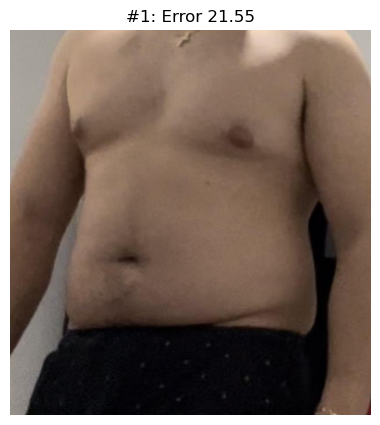

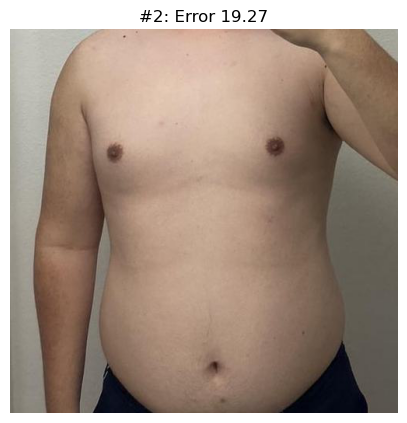

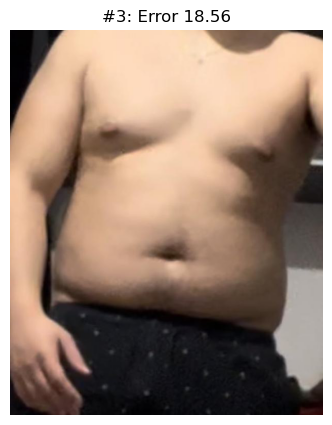

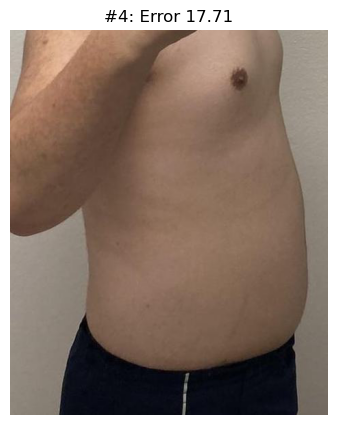

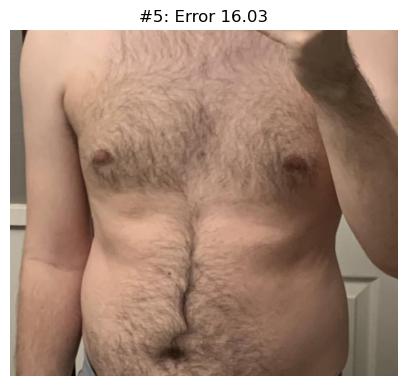

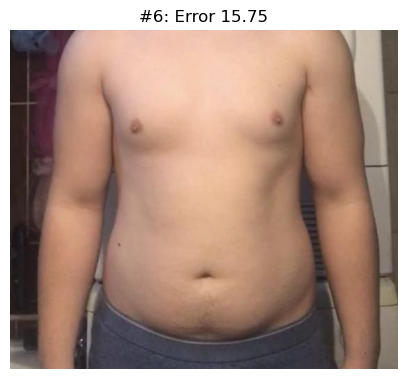

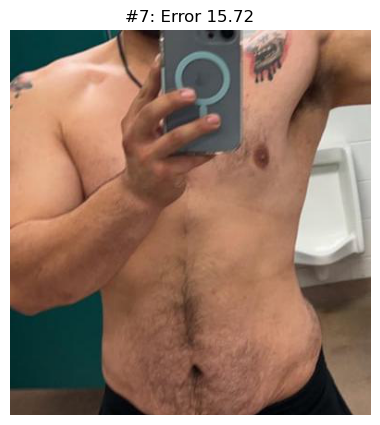

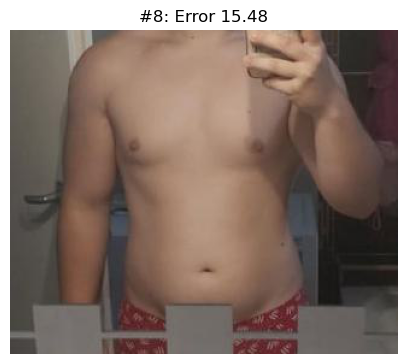

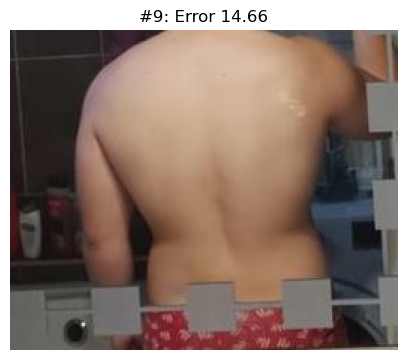

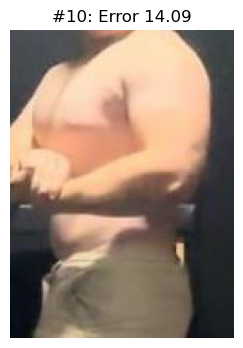

In [31]:
errors = []

pbar = tqdm(df.iterrows(), total=len(df), desc="Processing images", leave=True)

for i, row in pbar:
    try:
        img_path = f"{row['filename']}"  # change if your image path differs
        img = PILImage.create('images/' + img_path)
        bf, _, probs = learn.predict(img)
        pred = float(probs[0])
        actual = float(row['target'])
        error = abs(pred - actual)

        errors.append({
            "img_path": img_path,
            "img": img,
            "actual": actual,
            "pred": pred,
            "error": error
        })

        # Optionally update progress bar postfix
        pbar.set_postfix({"last_error": f"{error:.2f}"})

    except Exception as e:
        pbar.write(f"Skipping {row['filename']} due to error: {e}")
        
# Sort and show top 10 worst predictions
top_errors = sorted(errors, key=lambda x: x['error'], reverse=True)[:10]

for idx, item in enumerate(top_errors):
    print(f"\n#{idx+1}")
    print(f"File: {item['img_path']}")
    print(f"Predicted: {item['pred']:.2f}")
    print(f"Actual: {item['actual']:.2f}")
    print(f"Error: {item['error']:.2f}")
    show_image(item['img'], title=f"#{idx+1}: Error {item['error']:.2f}")


In [32]:
df_errors = pd.DataFrame(data, columns=headers)

errors.hist(bins=20)

NameError: name 'data' is not defined

In [ ]:
import io
from ipywidgets import widgets, VBox, HBox
from IPython.display import display

def pil_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    return buf.getvalue()

rows = []
for idx, item in enumerate(top_errors):
    img_bytes = pil_to_bytes(item['img'])
    img_widget = widgets.Image(value=img_bytes, format='png', width=200, height=200)
    
    text_html = f"""
    <b>#{idx+1}</b><br>
    File: {item['img_path']}<br>
    Predicted: {item['pred']:.2f}<br>
    Actual: {item['actual']:.2f}<br>
    Error: {item['error']:.2f}
    """
    text_widget = widgets.HTML(value=text_html)
    
    row = HBox([img_widget, text_widget])
    rows.append(row)

display(VBox(rows))


In [ ]:
df['target'].hist(bins=20)

In [ ]:
df_others = pd.read_csv("data/bodyfat_dataset.csv")

print(df_others.loc[655-5:655+2])
print(df[df['filename'] == "655_image_1.jpg"])

In [ ]:
model_paths = [
    "resnet34", 
    "resnet101",
    "efficientnet_b3",
    "efficientnet_b3_rmce",
]

learners = []

In [ ]:
for model_path in model_paths:
    learn = load_learner("model/" + model_path + "/model.pkl")
    learners.append(learn)

def ensemble_predict(items):
    preds_all = []
    for learn in learners:
        preds = learn.get_preds(dl=learn.dls.test_dl(items))[0]  # get_preds returns tuple, first is preds
        preds_all.append(preds)
    
    # Stack predictions: shape = (num_models, num_items)
    preds_stack = torch.stack(preds_all)
    
    # Average across models (dim=0)
    preds_mean = preds_stack.mean(dim=0)
    return preds_mean



In [ ]:
pred = ensemble_predict('images/1_image_1.jpg')
pred

In [ ]:
from fastai.vision.all import PILImage, show_image
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/image_labels.csv")

errors = []

pbar = tqdm(df.iterrows(), total=len(df), desc="Processing images", leave=True)

for i, row in pbar:
    try:
        img_path = f"{row['filename']}"  # change if your image path differs
        probs = ensemble_predict(img_path)
        pred = float(probs[0])
        actual = float(row['target'])
        error = abs(pred - actual)

        errors.append({
            "img_path": img_path,
            "img": img,
            "actual": actual,
            "pred": pred,
            "error": error
        })

        # Optionally update progress bar postfix
        pbar.set_postfix({"last_error": f"{error:.2f}"})

    except Exception as e:
        pbar.write(f"Skipping {row['filename']} due to error: {e}")
        
# Sort and show top 10 worst predictions
top_errors = sorted(errors, key=lambda x: x['error'], reverse=True)[:10]

for idx, item in enumerate(top_errors):
    print(f"\n#{idx+1}")
    print(f"File: {item['img_path']}")
    print(f"Predicted: {item['pred']:.2f}")
    print(f"Actual: {item['actual']:.2f}")
    print(f"Error: {item['error']:.2f}")
    show_image(item['img'], title=f"#{idx+1}: Error {item['error']:.2f}")


In [ ]:
import io
from ipywidgets import widgets, VBox, HBox
from IPython.display import display

def pil_to_bytes(img):
    buf = io.BytesIO()
    img.save(buf, format='PNG')
    return buf.getvalue()

rows = []
for idx, item in enumerate(top_errors):
    img_bytes = pil_to_bytes(item['img'])
    img_widget = widgets.Image(value=img_bytes, format='png', width=200, height=200)
    
    text_html = f"""
    <b>#{idx+1}</b><br>
    File: {item['img_path']}<br>
    Predicted: {item['pred']:.2f}<br>
    Actual: {item['actual']:.2f}<br>
    Error: {item['error']:.2f}
    """
    text_widget = widgets.HTML(value=text_html)
    
    row = HBox([img_widget, text_widget])
    rows.append(row)

display(VBox(rows))
